In [2]:
%load_ext autoreload
%autoreload
import os
import torch 
d = torch.device('cuda:3')
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from RS.utils.dictutils import *
from sklearn.preprocessing import normalize
from RS.utils.dataset import Dataset as Mydataset
from RS.utils.evaluation import Evaluate
from RS.utils.evaluation import zoom_in_topK
dataroot = os.path.join("data")

# Recommend

In [14]:
all_cates = list(str(i) for i in range(1000))

datafolder = {
    "training_user_course":os.path.join(
        dataroot,"course","train.csv"
    ),
    "training_user_book":os.path.join(
        dataroot,"book","user_cate3_train.csv"
    ),
    "testing_user_course":os.path.join(
        dataroot, "course", "test.csv"
    ),
    "testing_user_book":os.path.join(
        dataroot, "book", "user_cate3_test.csv"
    )
}

dataset = Mydataset(datafolder=datafolder)

build dataset
read training_user_course:data/course/train.csv
..OK
read training_user_book:data/book/user_cate3_train.csv
..OK
read testing_user_course:data/course/test.csv
..OK
read testing_user_book:data/book/user_cate3_test.csv
..OK


## Popular books (baseline)
Uisng popluar Book (2021) as coldstart recommended list 

In [5]:
popular_savepath = os.path.join("result", "popular")

In [12]:
popluar = loadjson(
    os.path.join(dataroot,"book", "popular","popular.json")
)['popular_2021']
print(popluar[:5])
print(len(popluar))

['563', '176', '579', '584', '805']
306


In [14]:
recommend_using_popular = {}
for testu in tqdm(
    dataset.getdata("testing_user_course").uid.tolist()
):
    recommend_using_popular[str(testu)] = popluar

writejson(
    recommend_using_popular,
    os.path.join(popular_savepath, "recommendlist.json")
)


100%|██████████| 1254/1254 [00:00<00:00, 1106597.35it/s]


### Evaluation

In [ ]:
Evaluate(
    result_root=popular_savepath, 
    recommendlist = os.path.join(popular_savepath, "recommendlist.json"),
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=all_cates,
    topN_range=len(popluar)
)

#### Zoom-in top K

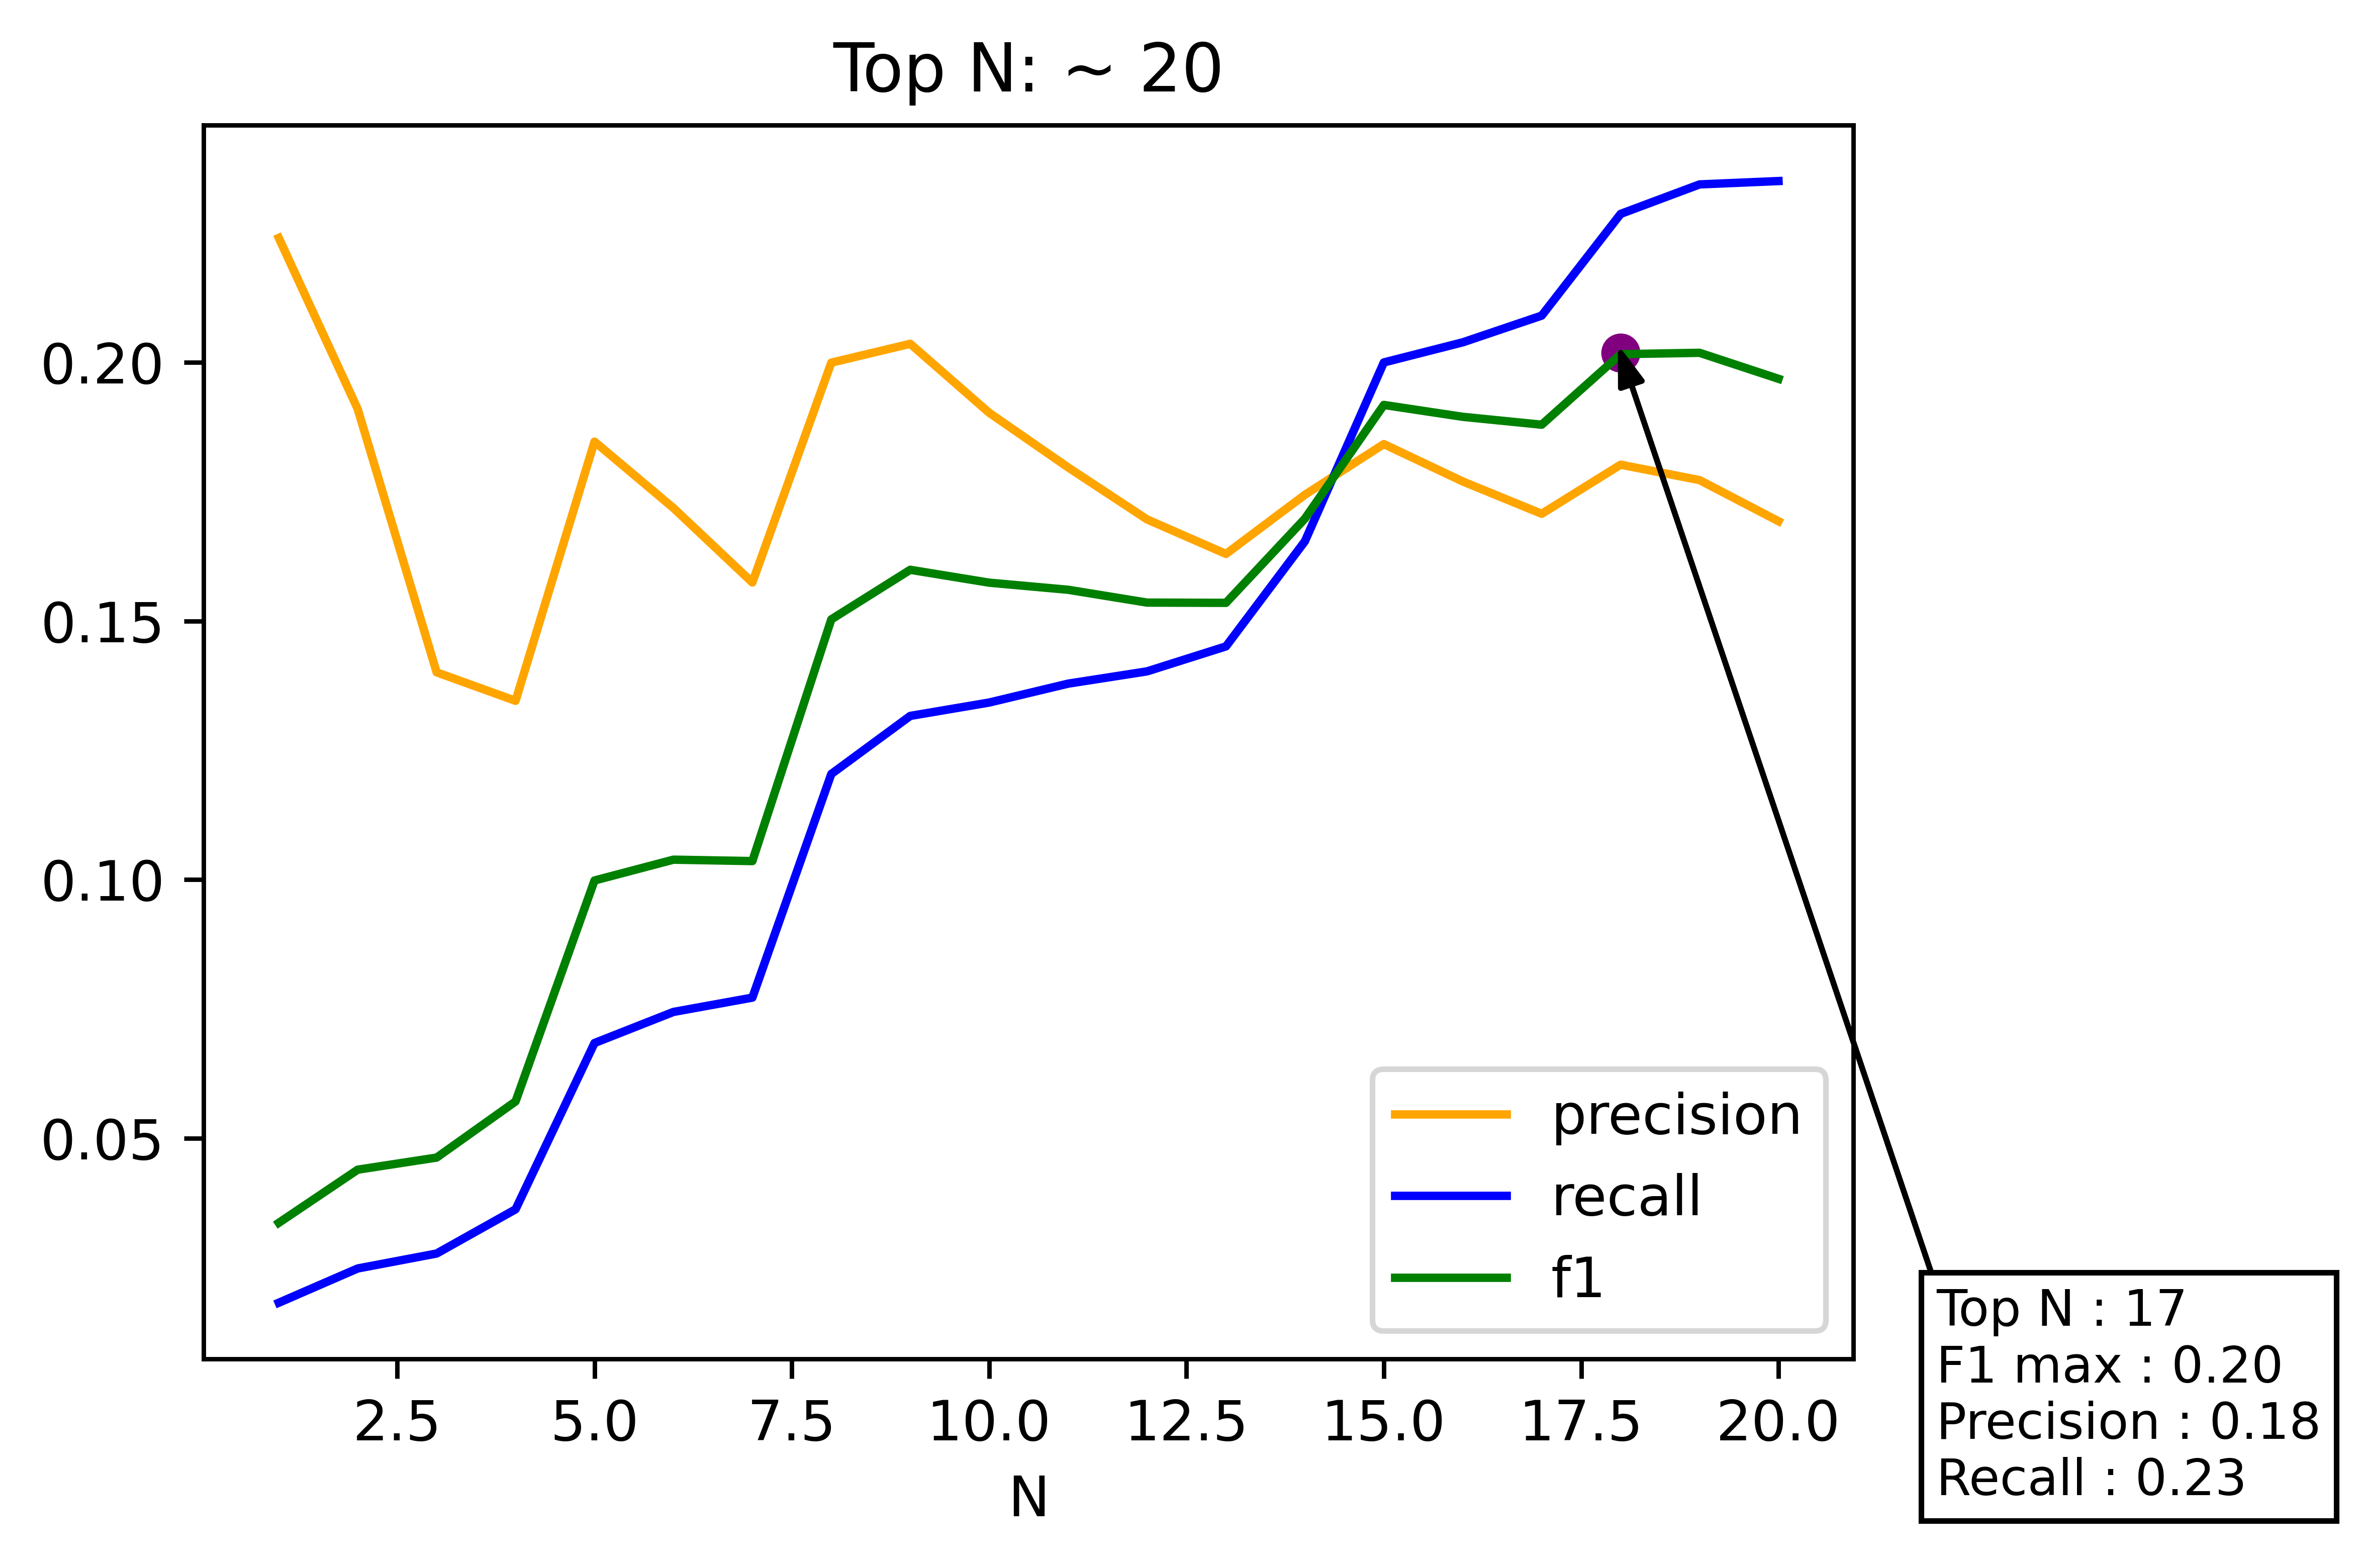

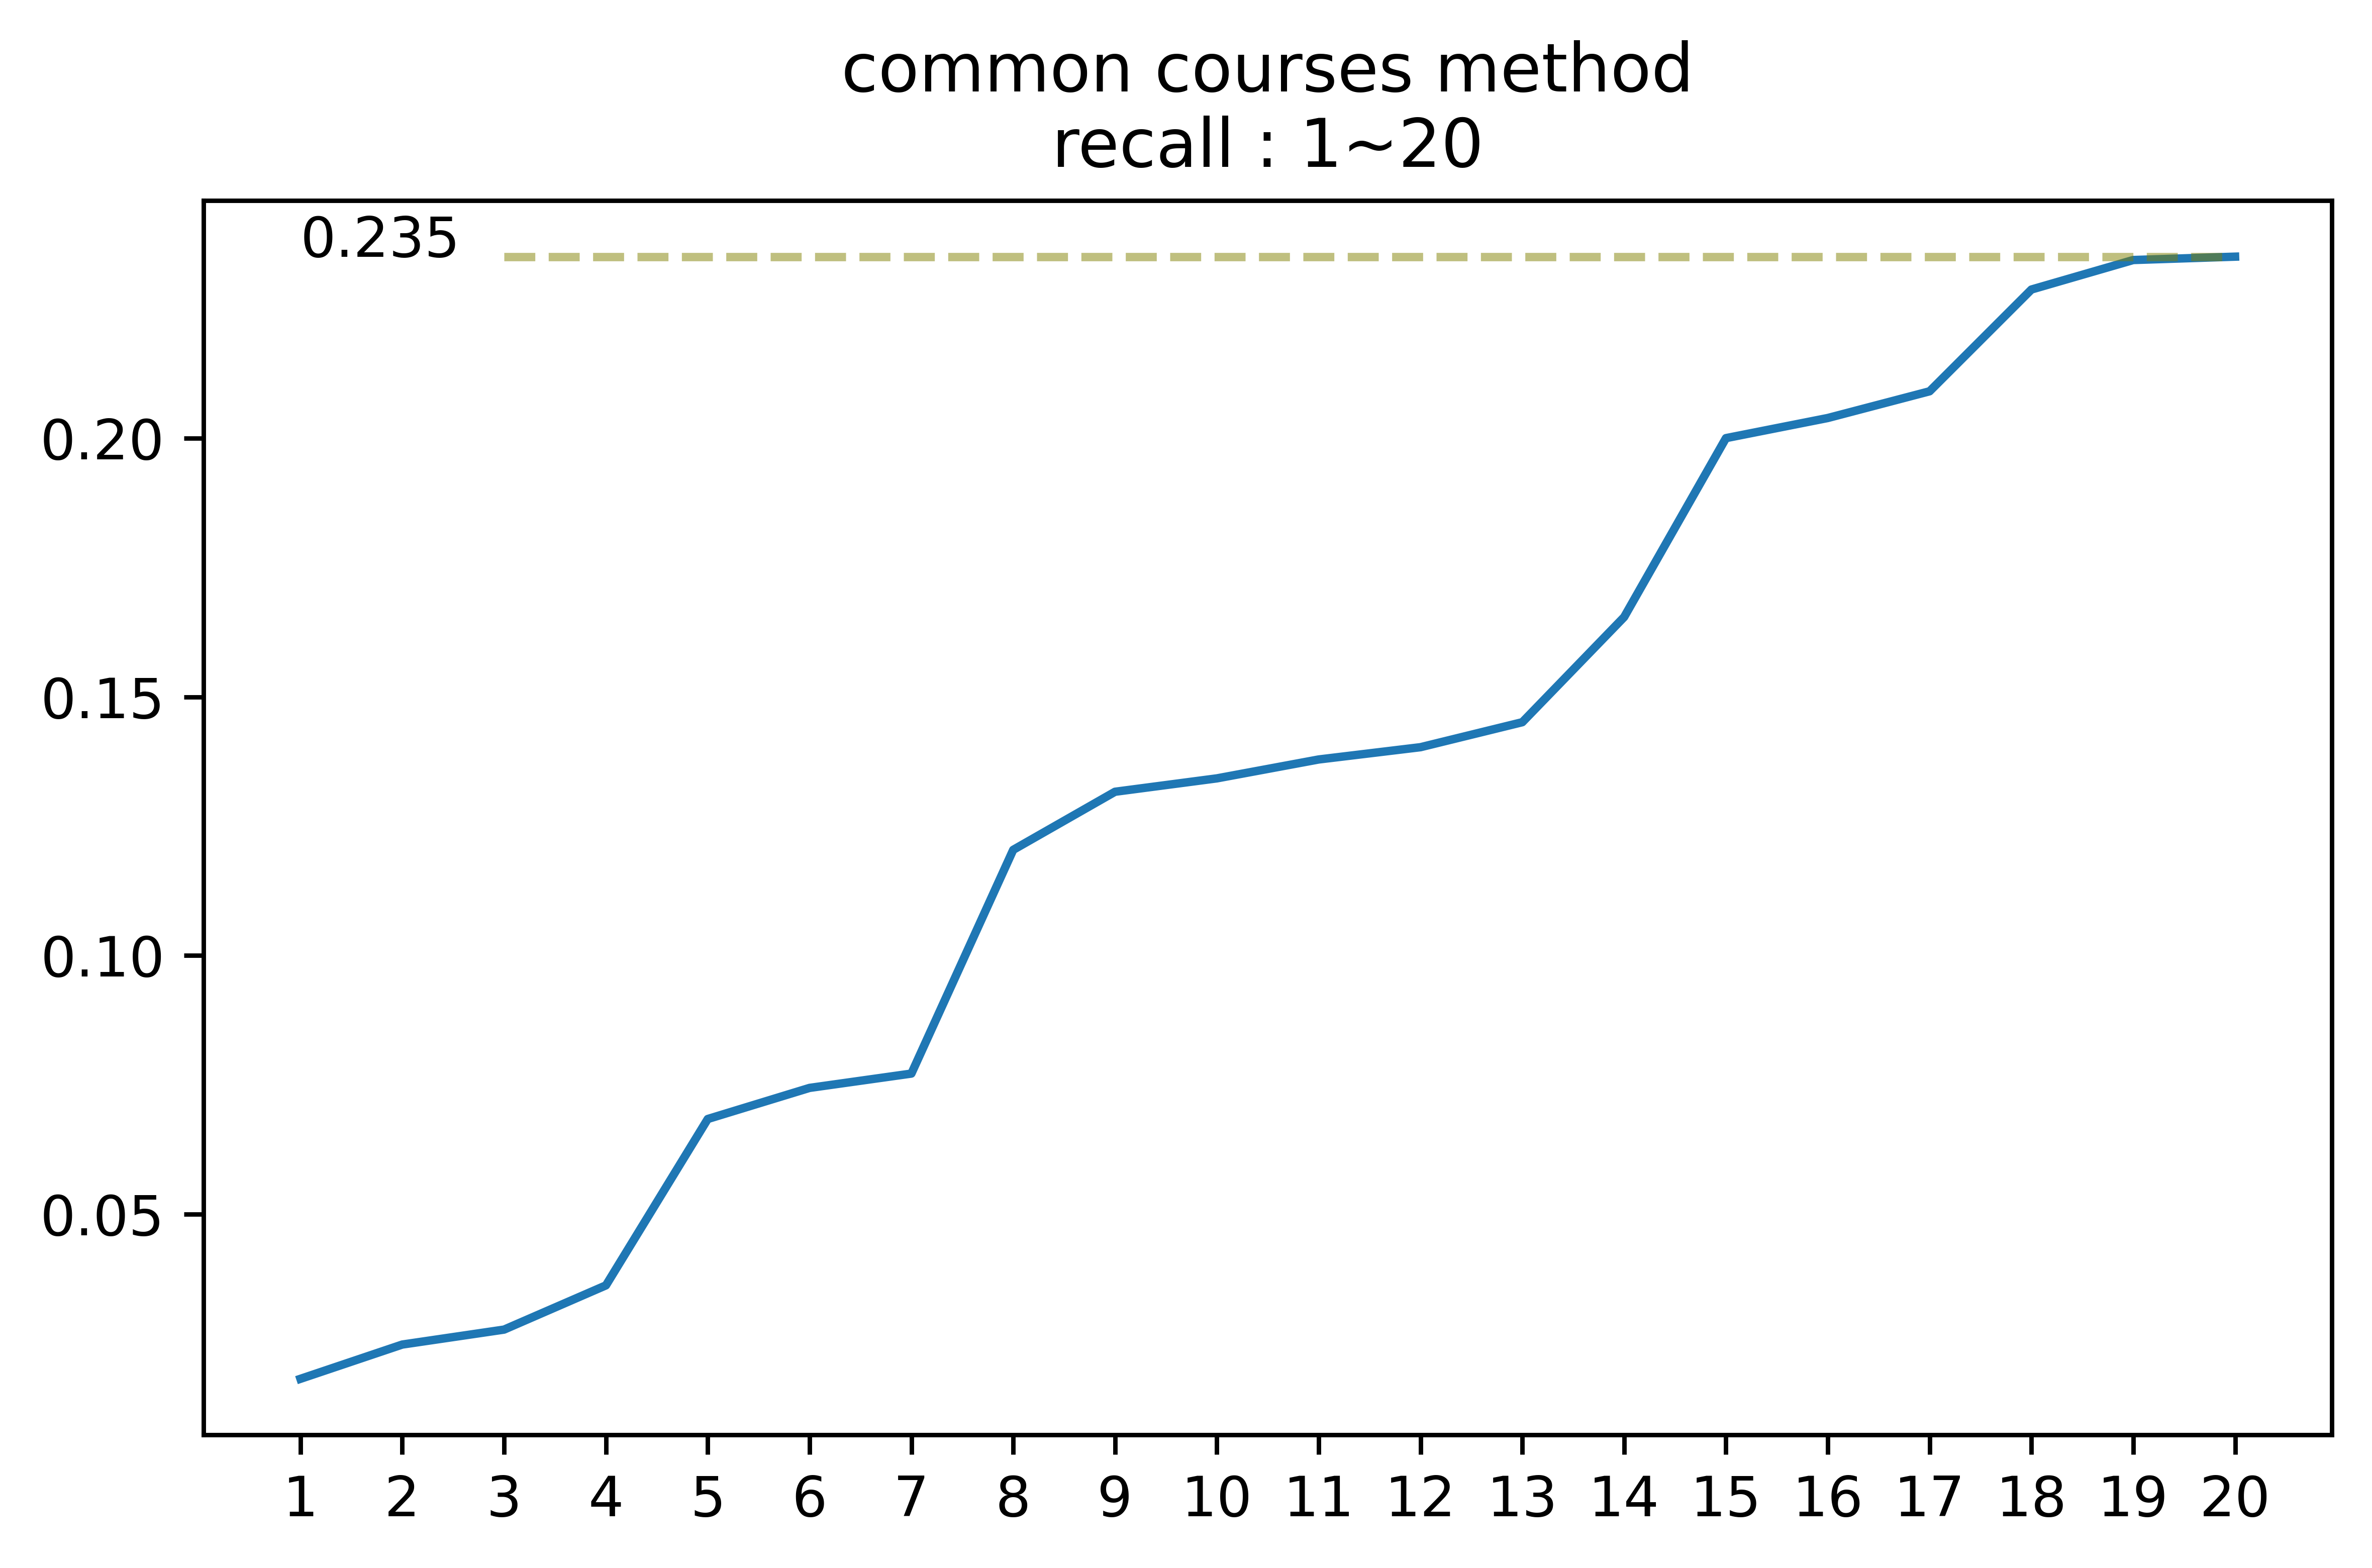

In [6]:
topk = 20
metrics = loadjson(
    os.path.join(popular_savepath,"metrics", "metrics.json")
)

zoom_in_topK(
    metrics=metrics,topk=topk,
    savepath=os.path.join(popular_savepath,"metrics"),
    showinline=True
)

## METHOD1
Using all courses that a user have had taken.  



In [82]:
%autoreload
from RS.commoncourse import \
    recommend_according_course_selection_records

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
commoncourse_savepath = os.path.join("result", "commoncourse")
if not os.path.exists(commoncourse_savepath):
    print(f"mkdir : {commoncourse_savepath}")
    os.mkdir(commoncourse_savepath)

### Steps:

1. __Generate__ $M_{category \times course}$

  - Input:
    - $M_{u_\text{train} \times category}$ : 
      - each entry $(u_j, cate_i)$ means the counts of category $cate_i$ being lended  by the trained-user $u_{j}$
    - $M_{u_{\text{train}} \times course}$ :
      - each entry $(u_j,course_k)$ means whether the trained-user $u_j$ had taken the course $course_k$. It is a binary matrix.

  - Output : 
    - $M_{category \times {course}}$: 
      - each entry of it means the mean counts of $category_i$ lended by the training students who had taken $course_j$.

  - Steps:
    1. $M_{norm, u_\text{train}\times course} := $ normalize $M_{u_\text{{train}} \times course}$ along it's column by $L_1$ norm.

    2. $M_{category \times {course}} \gets M_{u_\text{{train}} \times category}^T \times  M_{norm, u_\text{{train}}\times course}$

    3. return  $M_{category \times {course}}$

2. Generate recommend list: 

    $\textbf{for}$ each ${u_{\text{test}_\text{t}}}\in $ testing users:

  - Input (from step 1. directly):
    - $M_{ij}$: 
      - Mean counts of $\text{category}_i$ lended by the training students who had taken $\text{course}_j$. 

    - $Course_{u_{\text{test}_\text{t}}}$: 
      - $\{course_{i} \textbf{ }| \textbf{ } course_{i} \in$  course selection records of  ${u_{\text{test}_\text{t}}} \}$.
    - $topN$: 
      - top-N categories needed to be recommended.
  - Output : 
    - topN Recommend categories for a cold-started user ${u_{\text{test}_\text{t}}}$

  - Steps :
    1. __initialize__ : $CategoryCount_{{u_{\text{test}_\text{t}}}} := [0]_{1 \times |categories|}$

    2. For {$category_i$ $\in$ all categories}
      - $CategoryCount_{u_{\text{test}_\text{t}}}[category_i] \gets \frac{ \displaystyle\sum_{course_j\in Course_{u_{\text{test}_\text{t}}}} M[category_i][course_j]}{|Course_{u_{\text{test}_\text{t}}}|}$

    3. return category indices of $topN$ maximum values of $CategoryCount_{u_{\text{test}_\text{t}}}$

In [11]:
rslist_saving_path = recommend_according_course_selection_records(
    dataset=dataset, resultroot=commoncourse_savepath, d=d
)

build book x user .. OK ..
prediction ..


100%|██████████| 1254/1254 [00:00<00:00, 1419.83it/s]


OK .. save at result/commoncourse/recommendlist.json


### Evaluation

In [53]:
rslist_saving_path=os.path.join(
    commoncourse_savepath, "recommendlist.json"
)

Evaluate(
    result_root=commoncourse_savepath, 
    recommendlist = rslist_saving_path,
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=all_cates
)

result/commoncourse/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [19:45<00:00,  1.19s/it]


Precision_Recall_F1 : result/commoncourse/metrics/metrics.jpg
PR : result/commoncourse/metrics/PR.jpg
ROC : result/commoncourse/metrics/ROC.jpg


#### Zoom-in top k

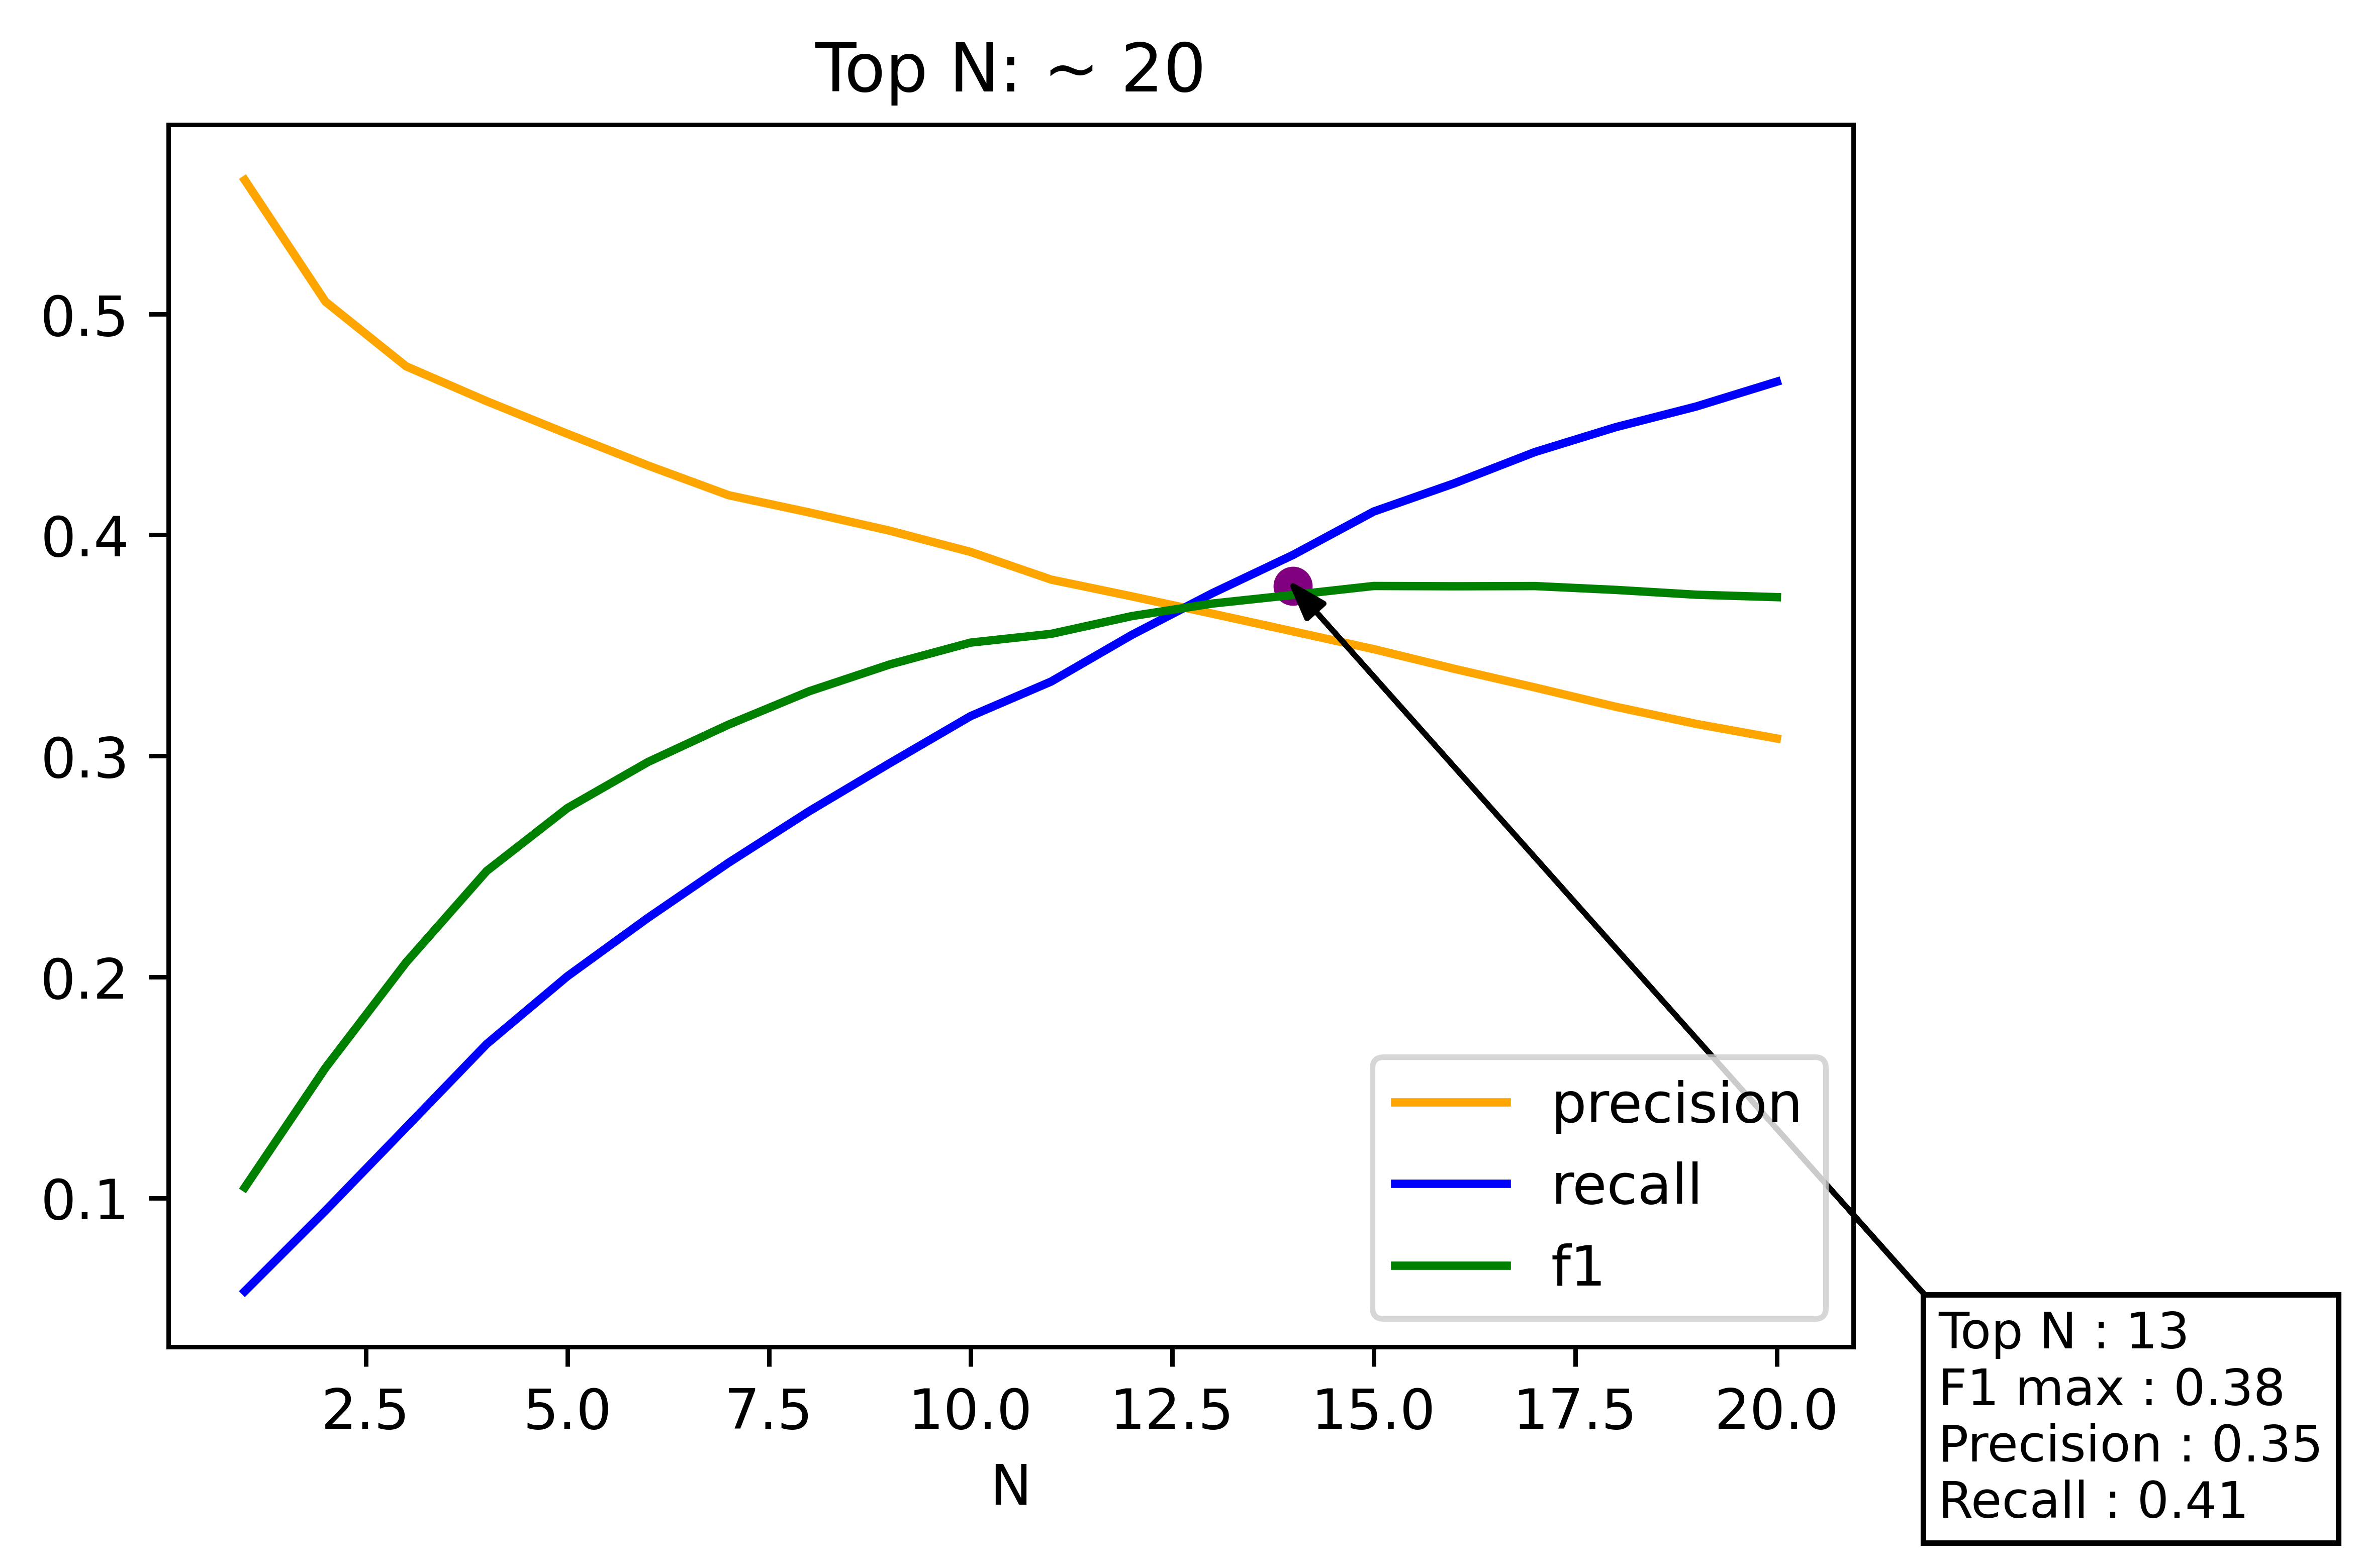

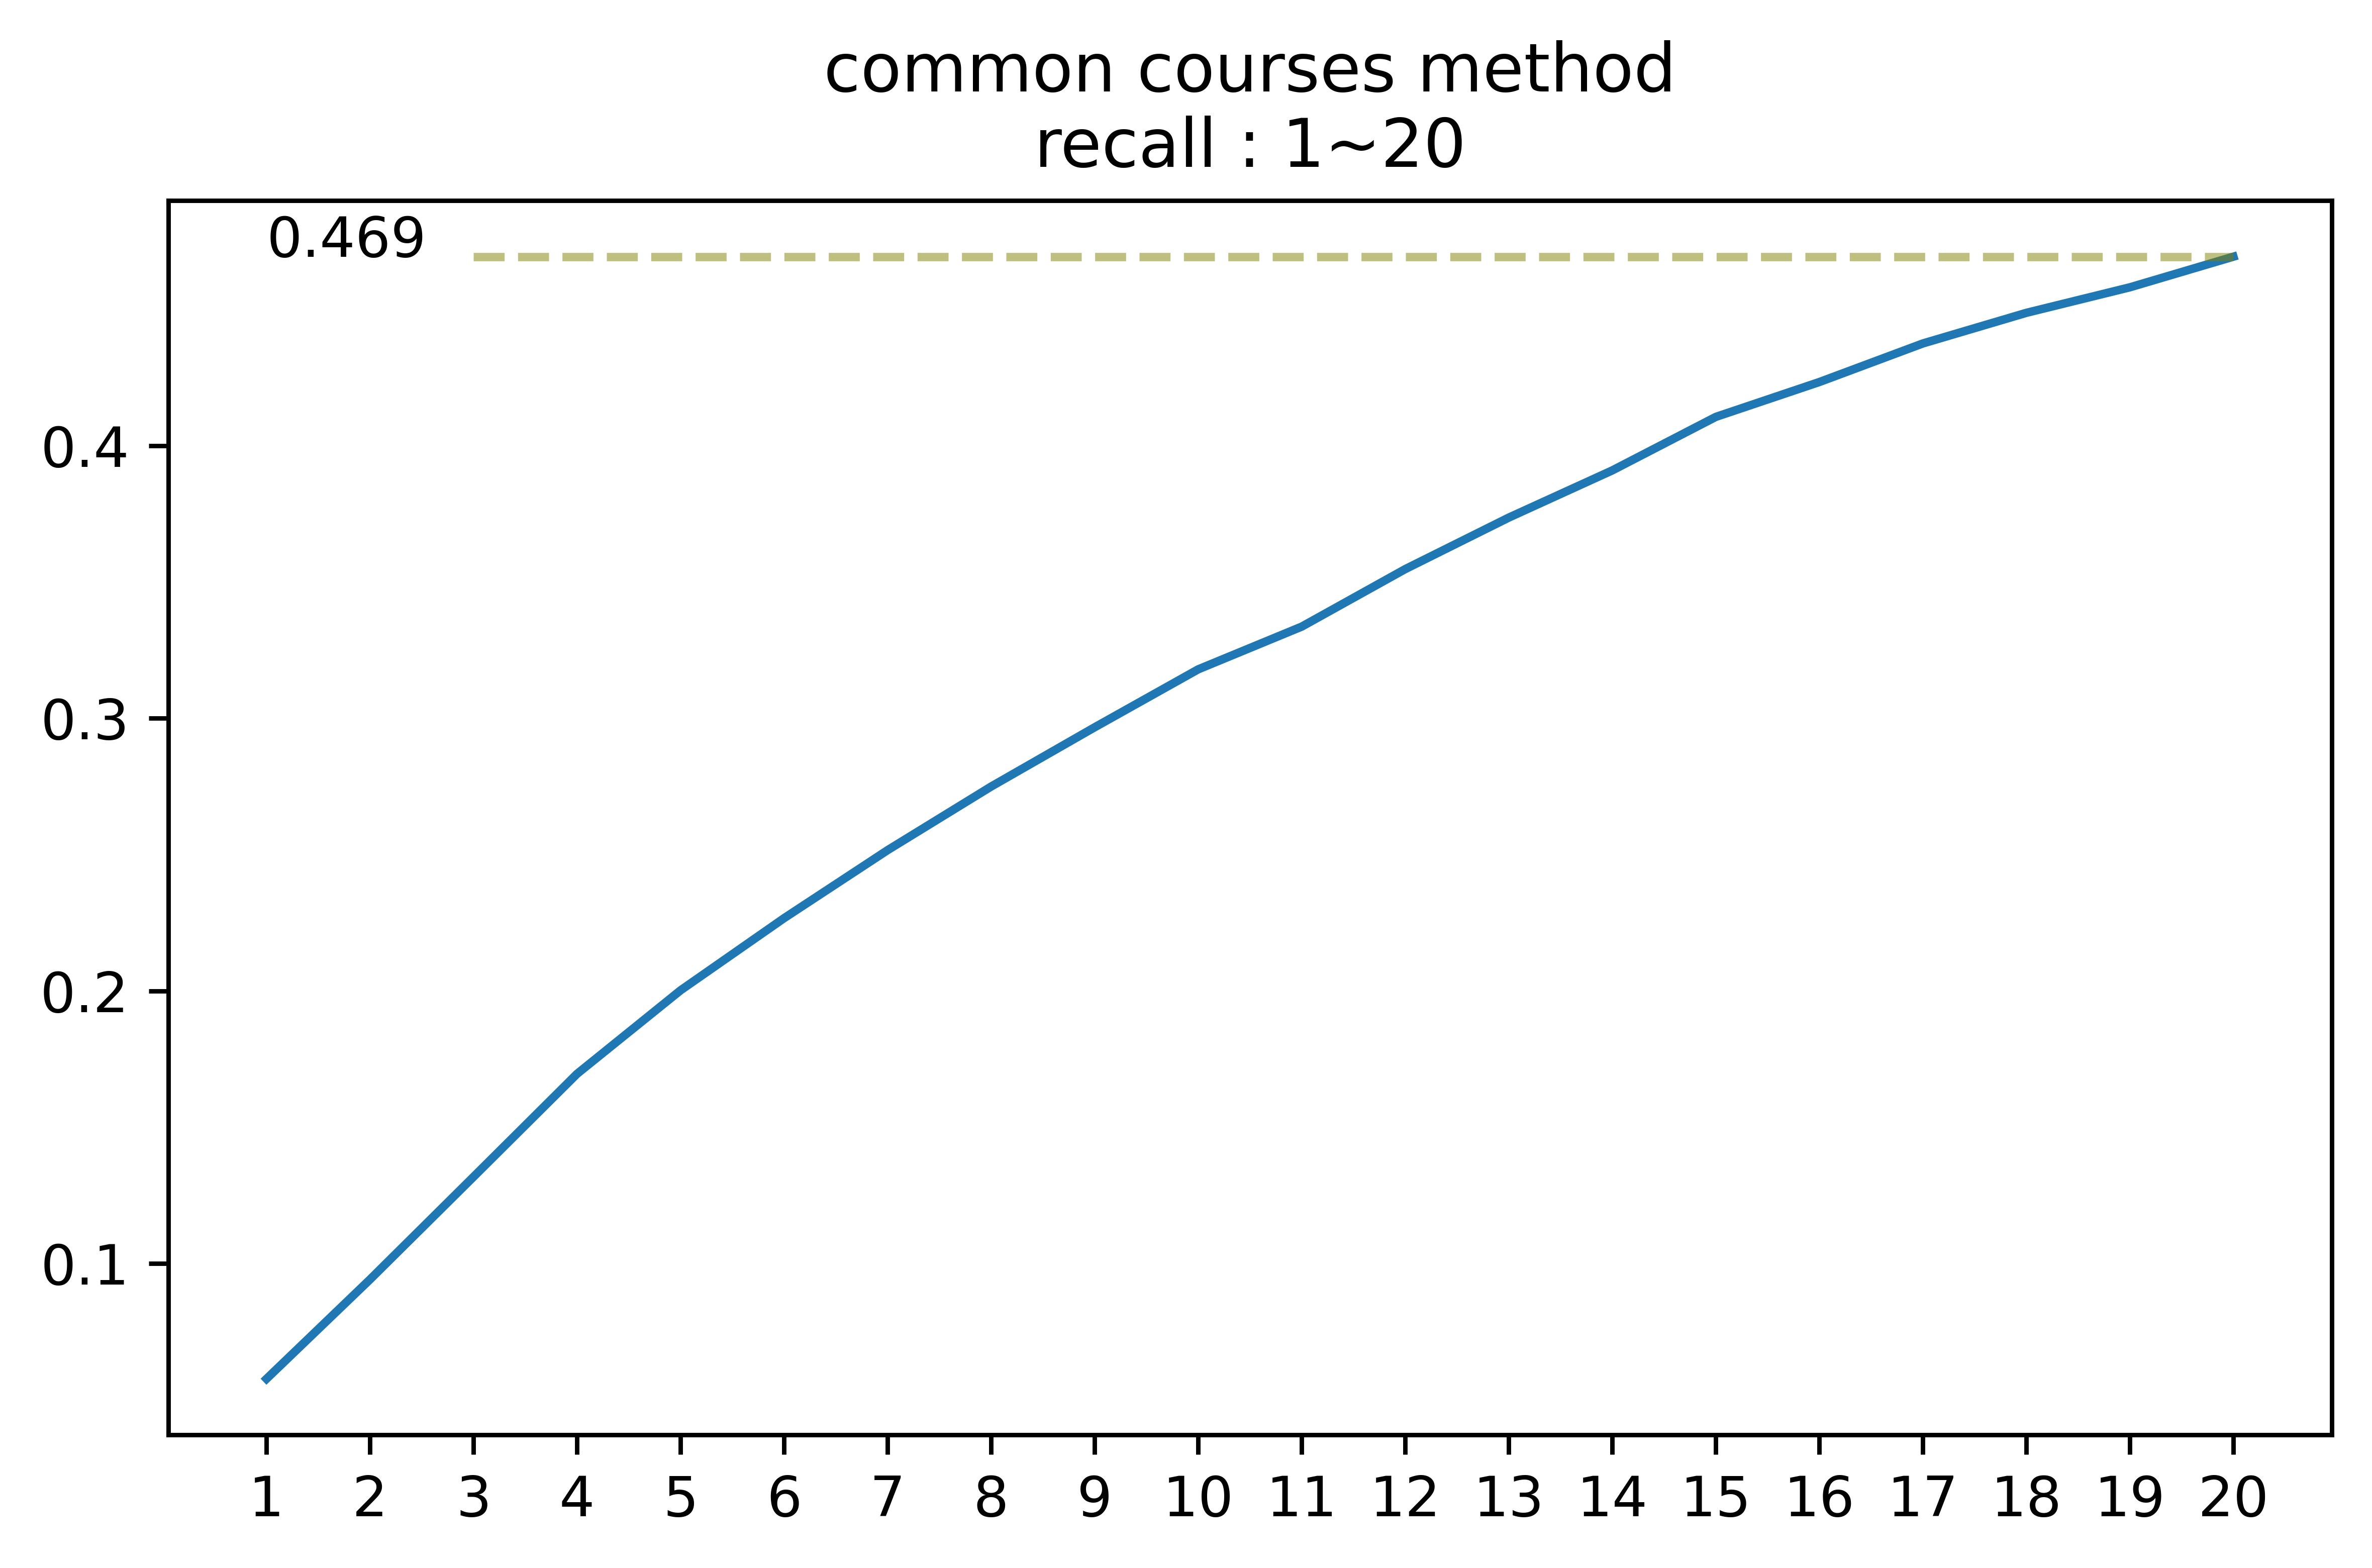

In [3]:
topk = 20
metrics = loadjson(
    os.path.join(
        commoncourse_savepath,"metrics","metrics.json"
    )
)
zoom_in_topK(
    metrics=metrics,topk=topk,
    savepath=os.path.join(commoncourse_savepath,"metrics"),
    showinline=True
)


## METHOD 2

CBMF

- reference: 
  - __Improving Top-N Recommendation for Cold-Start Users via Cross-Domain Information__
  - Authors: 
    Nima Mirbakhsh, Charles X. Ling
    
  - ACM Transactions on Knowledge Discovery from DataVolume 9Issue 4June 2015

In [7]:
cbmf_savepath = os.path.join("result", "CBMF")
if not os.path.exists(cbmf_savepath):
    print(f"mkdir : {cbmf_savepath}")
    os.mkdir(cbmf_savepath)
    os.mkdir(os.path.join(cbmf_savepath, "metrics"))

#### Build Cross Domain user item matrix

In [12]:
%autoreload
from RS.utils.dataset import build_cross_domain_matrix

$$\begin{bmatrix}
&|&\text{book}_1&\text{book}_2&...&|&\text{course}_1&\text{course}_2&...\\
--&--&--&--&--&--&--&--&--&\\
u_{\text{train}_1}&|&&&&|\\
u_{\text{train}_2}&|&&&&|\\
...&|&&&&|\\
--&--&--&--&--&--&--&--&--&\\
u_{\text{test}_1}&|&&&&|\\
u_{\text{test}_1}&|&&&&|\\
...&|&&&&|\\
\end{bmatrix}$$

In [15]:
info, cross_matrix = build_cross_domain_matrix(
    dataset=dataset,
    domains=[
        [   
            ("training_user_book",False,False),
            ("testing_user_book",True,False)
        ],
        [
            ("training_user_course", False, False),
            ("testing_user_course",False,False)
        ]
    ],
    savedir=os.path.join(dataroot, "crossdomain", "origin"),
    return_data="torch"  
)

name : training_user_book, mask: False, normalization: False
    normalization along row : False
name : testing_user_book, mask: True, normalization: False
     mask up
name : training_user_course, mask: False, normalization: False
    normalization along row : False
name : testing_user_course, mask: False, normalization: False
    normalization along row : False
save cross domain df to : data/crossdomain/origin/cross_domain.csv
save cross domain matrix to : data/crossdomain/origin/cross_domain


In [16]:
%autoreload
from RS.mf_based import Cross_MF

### Non Clustering 

#### MF

In [ ]:
# for halfway execution
# If continuously execute from
# Build Cross Domain user item matrix,
# There is no needed to execute this block

cross_matrix = torch.tensor(
    np.load(
        os.path.join(dataroot, "crossdomain",
        "normalize","cross_domain.npy"
        )
    ),
    dtype=torch.double
)

info = loadjson(
    os.path.join(dataroot, "crossdomain","info.json")
)

MF .. 
WeightedALS_MF
random loss: 101.7114640740536


100%|██████████| 3/3 [05:31<00:00, 110.55s/it, currentbest=0.101, mse=0.102, improve=-0.0005, early=0] 


MF done ..
generate recommend list ..


100%|██████████| 1254/1254 [00:00<00:00, 2880.99it/s]


done .., recommend list is at result/CBMF/nonclustering/origin/recommendlist.json


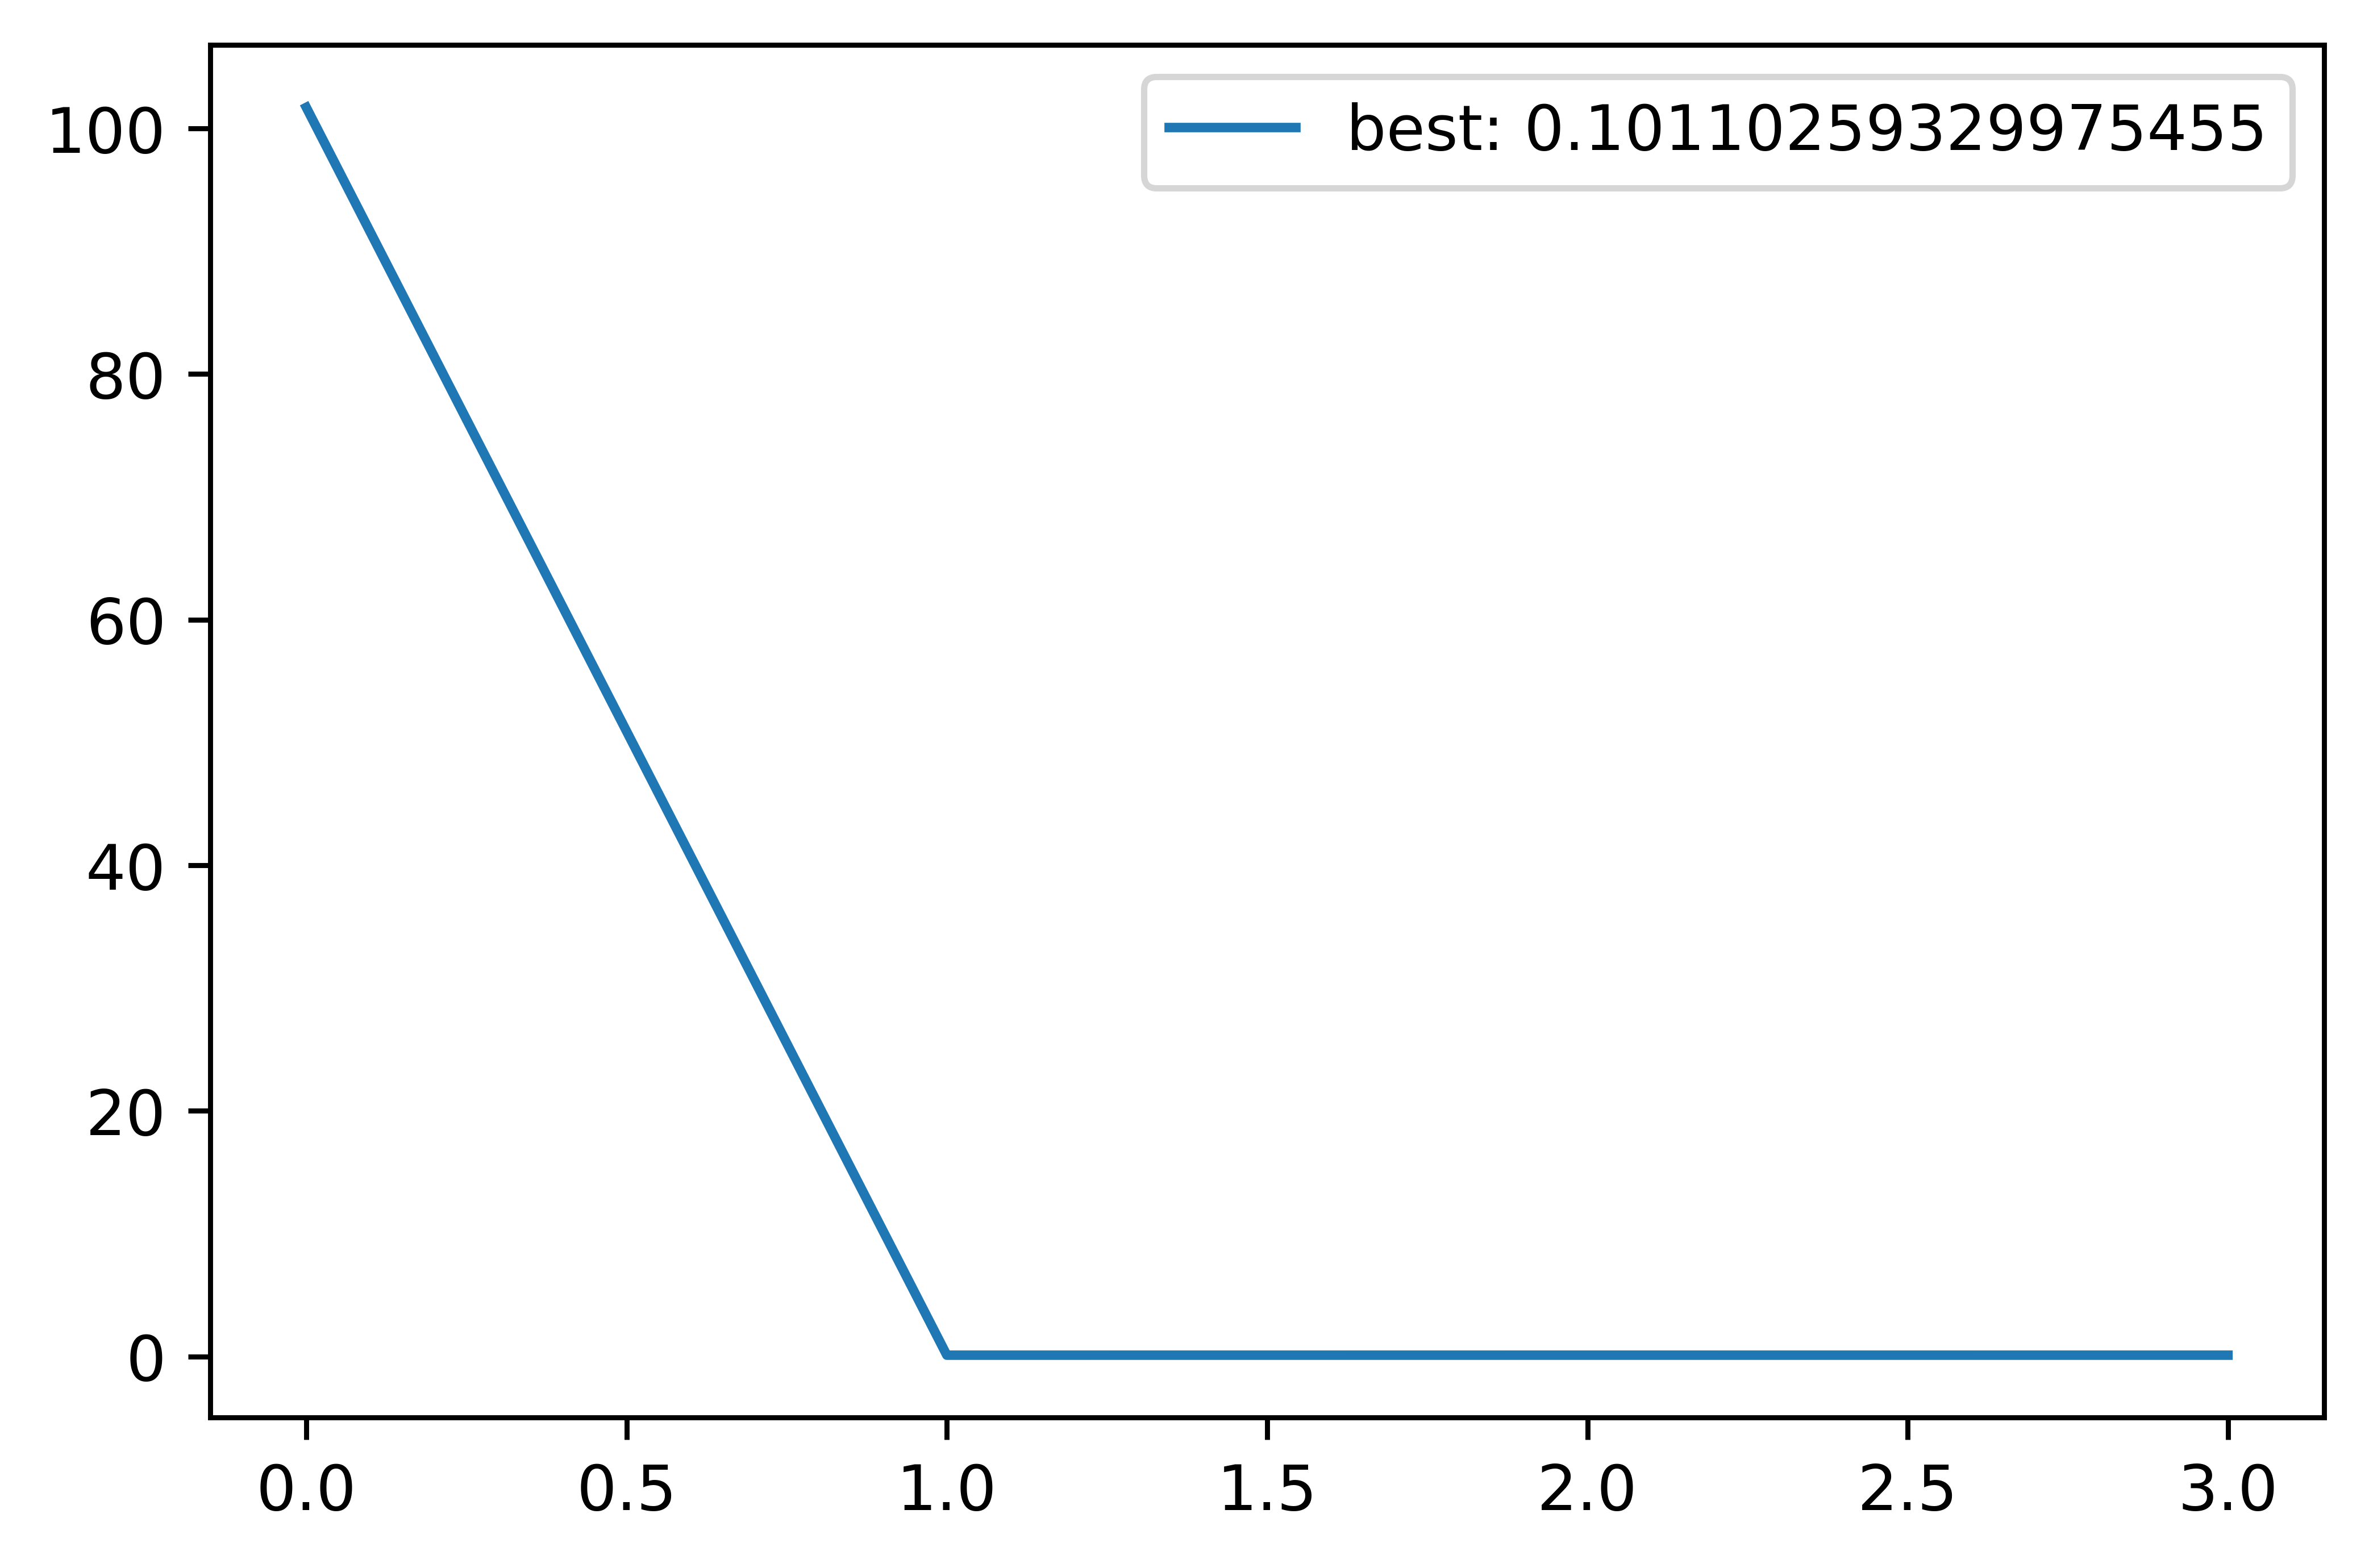

In [17]:
mf_args = {
    'latency':40,'l2_reg':0.1,
    'fill_empty':torch.mean(cross_matrix).item(),
    'w_obs':1, 'w_m':0.001,
    'epochs':3
}
recommend_list_path = Cross_MF(
    cross_matrix=cross_matrix,
    testing_range=info['testing_range'],
    testing_user=info['testing_user'],
    model="WeightedALS_MF", model_args=mf_args,
    on_device=d,
    model_save_path=os.path.join(
        cbmf_savepath,"nonclustering","origin","model"
    ),
    result_saving_path=os.path.join(
        cbmf_savepath,"nonclustering","origin"
    ),
    show_loss=True
) 

#### Evaluation

In [ ]:
# for halfway execution
# If continuously execute from
# MF,
# There is no needed to execute this block

recommend_list_path=os.path.join(
    cbmf_savepath,"nonclustering","origin","recommendlist.json"
)

In [ ]:
Evaluate(
    result_root = os.path.join(cbmf_savepath, "nonclustering","origin"), 
    recommendlist = recommend_list_path,
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=all_cates
)

### Zoom in top-k

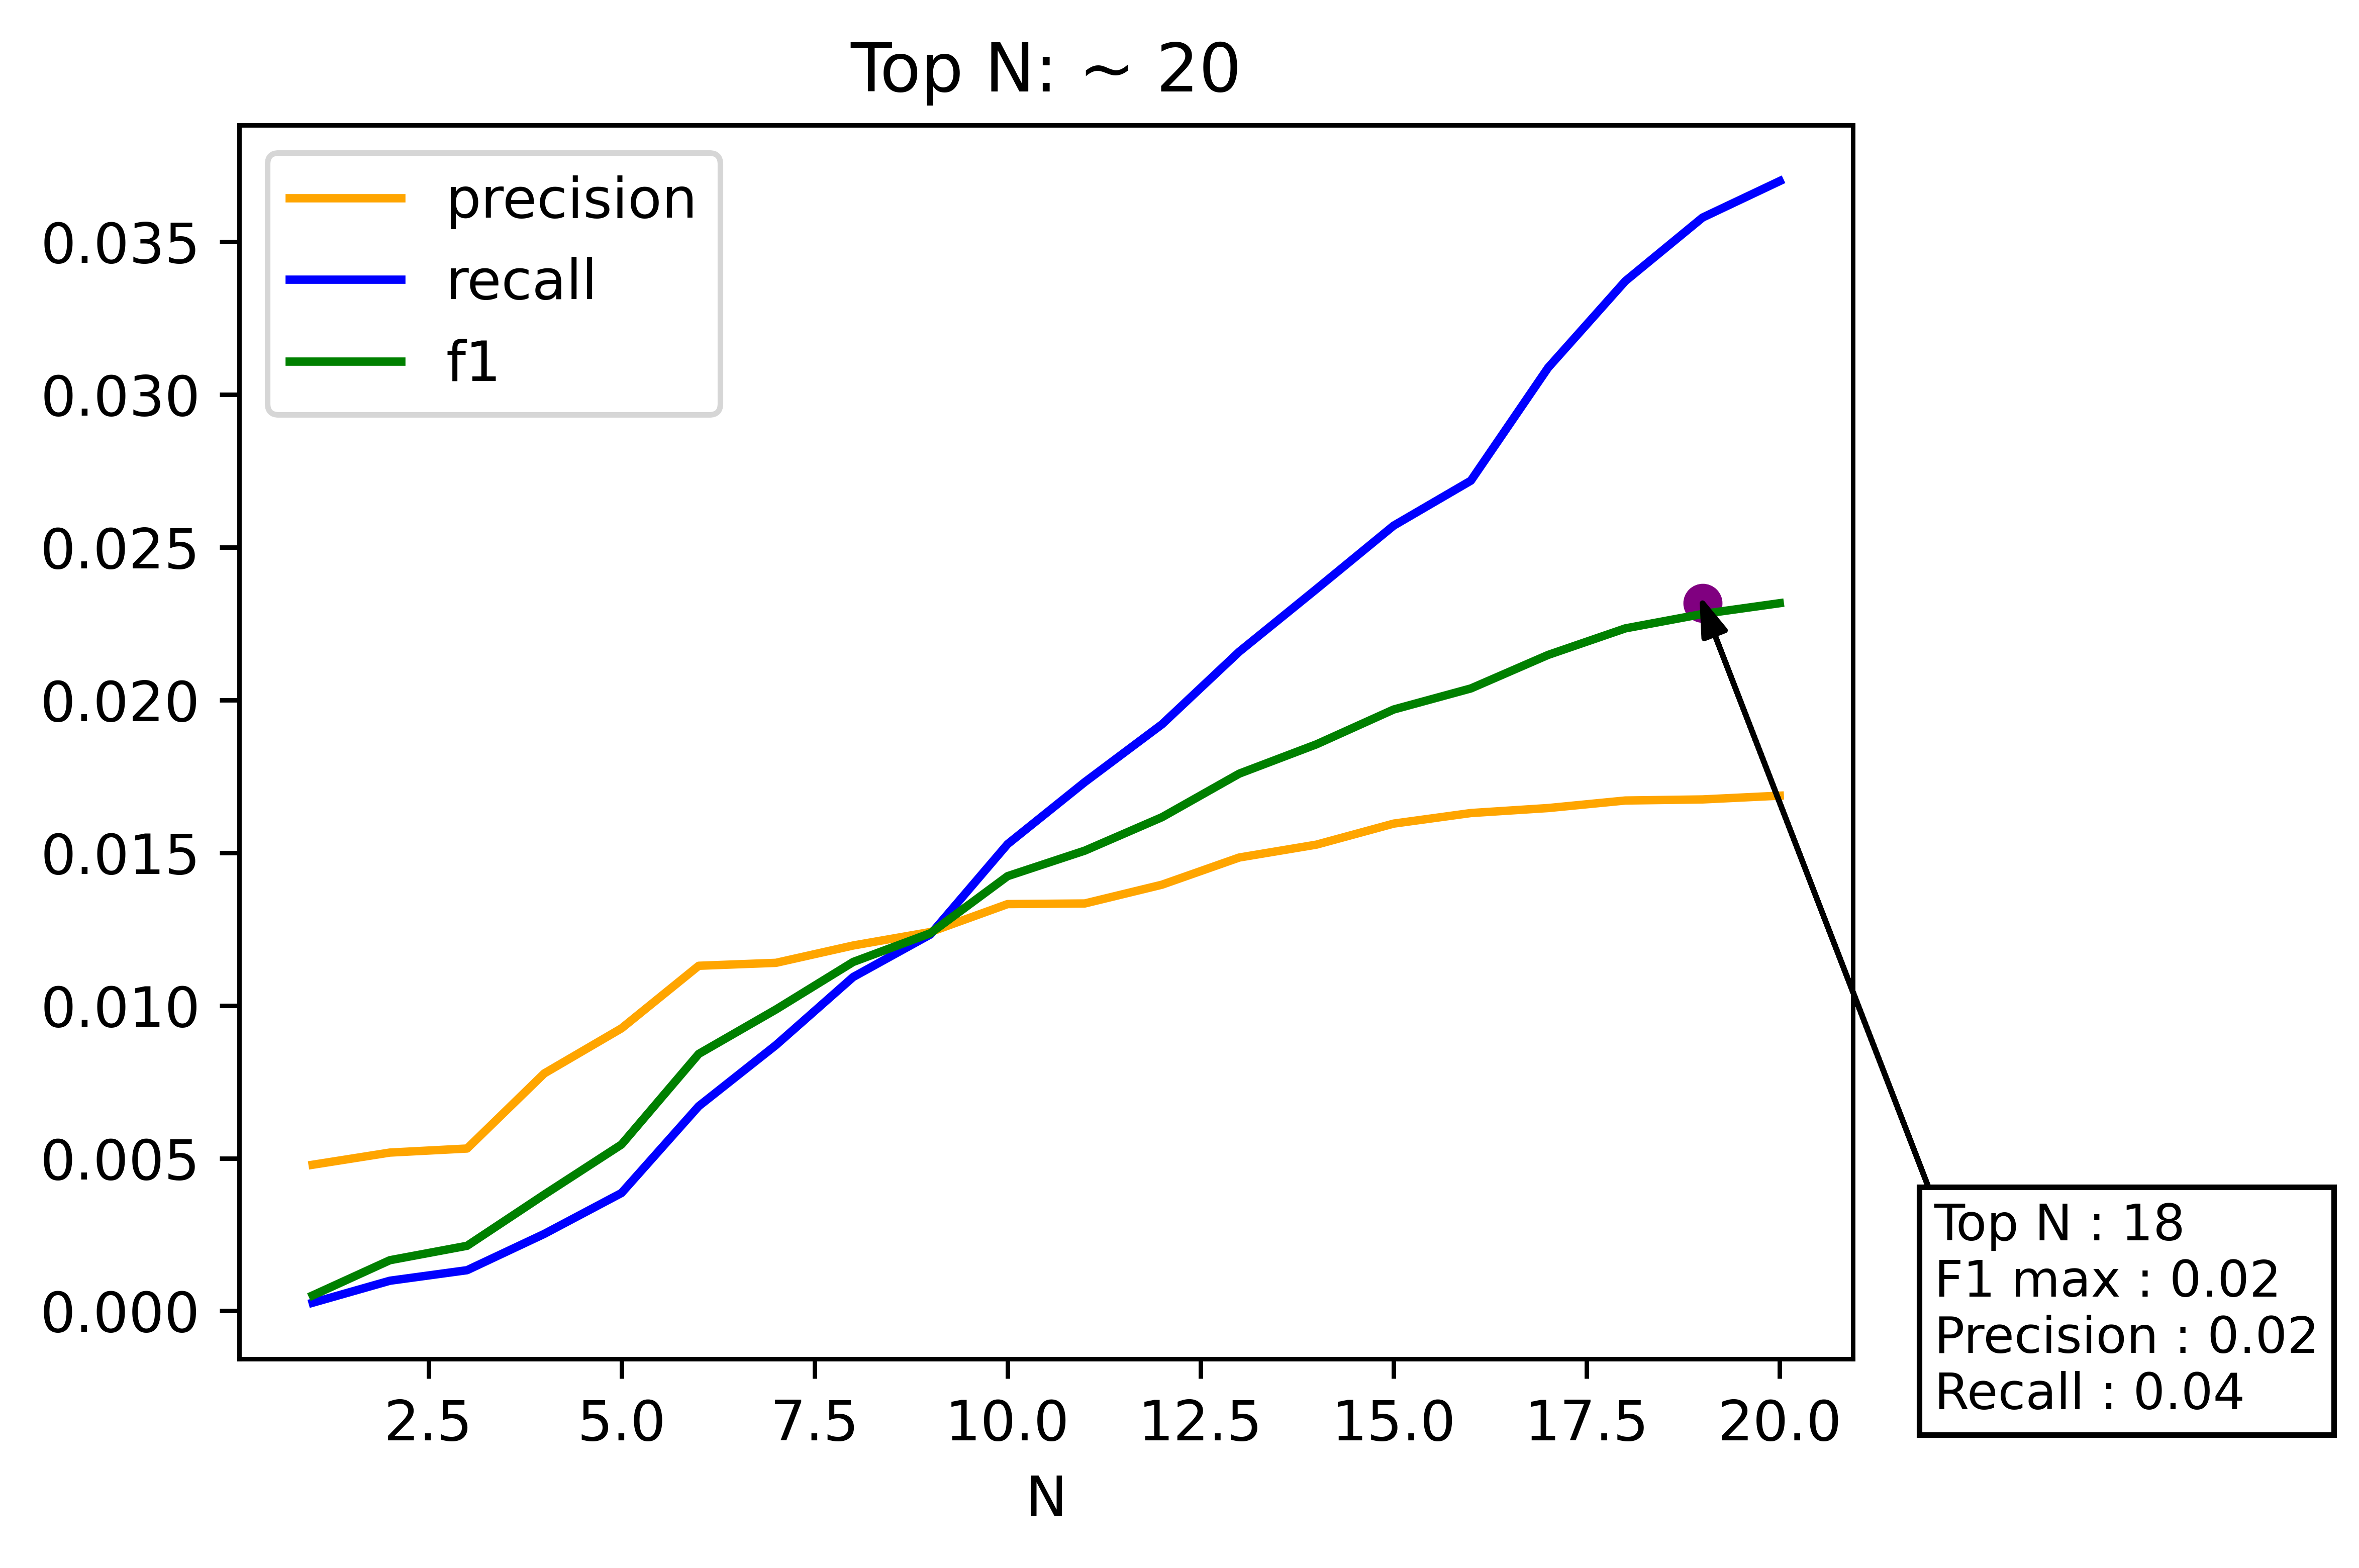

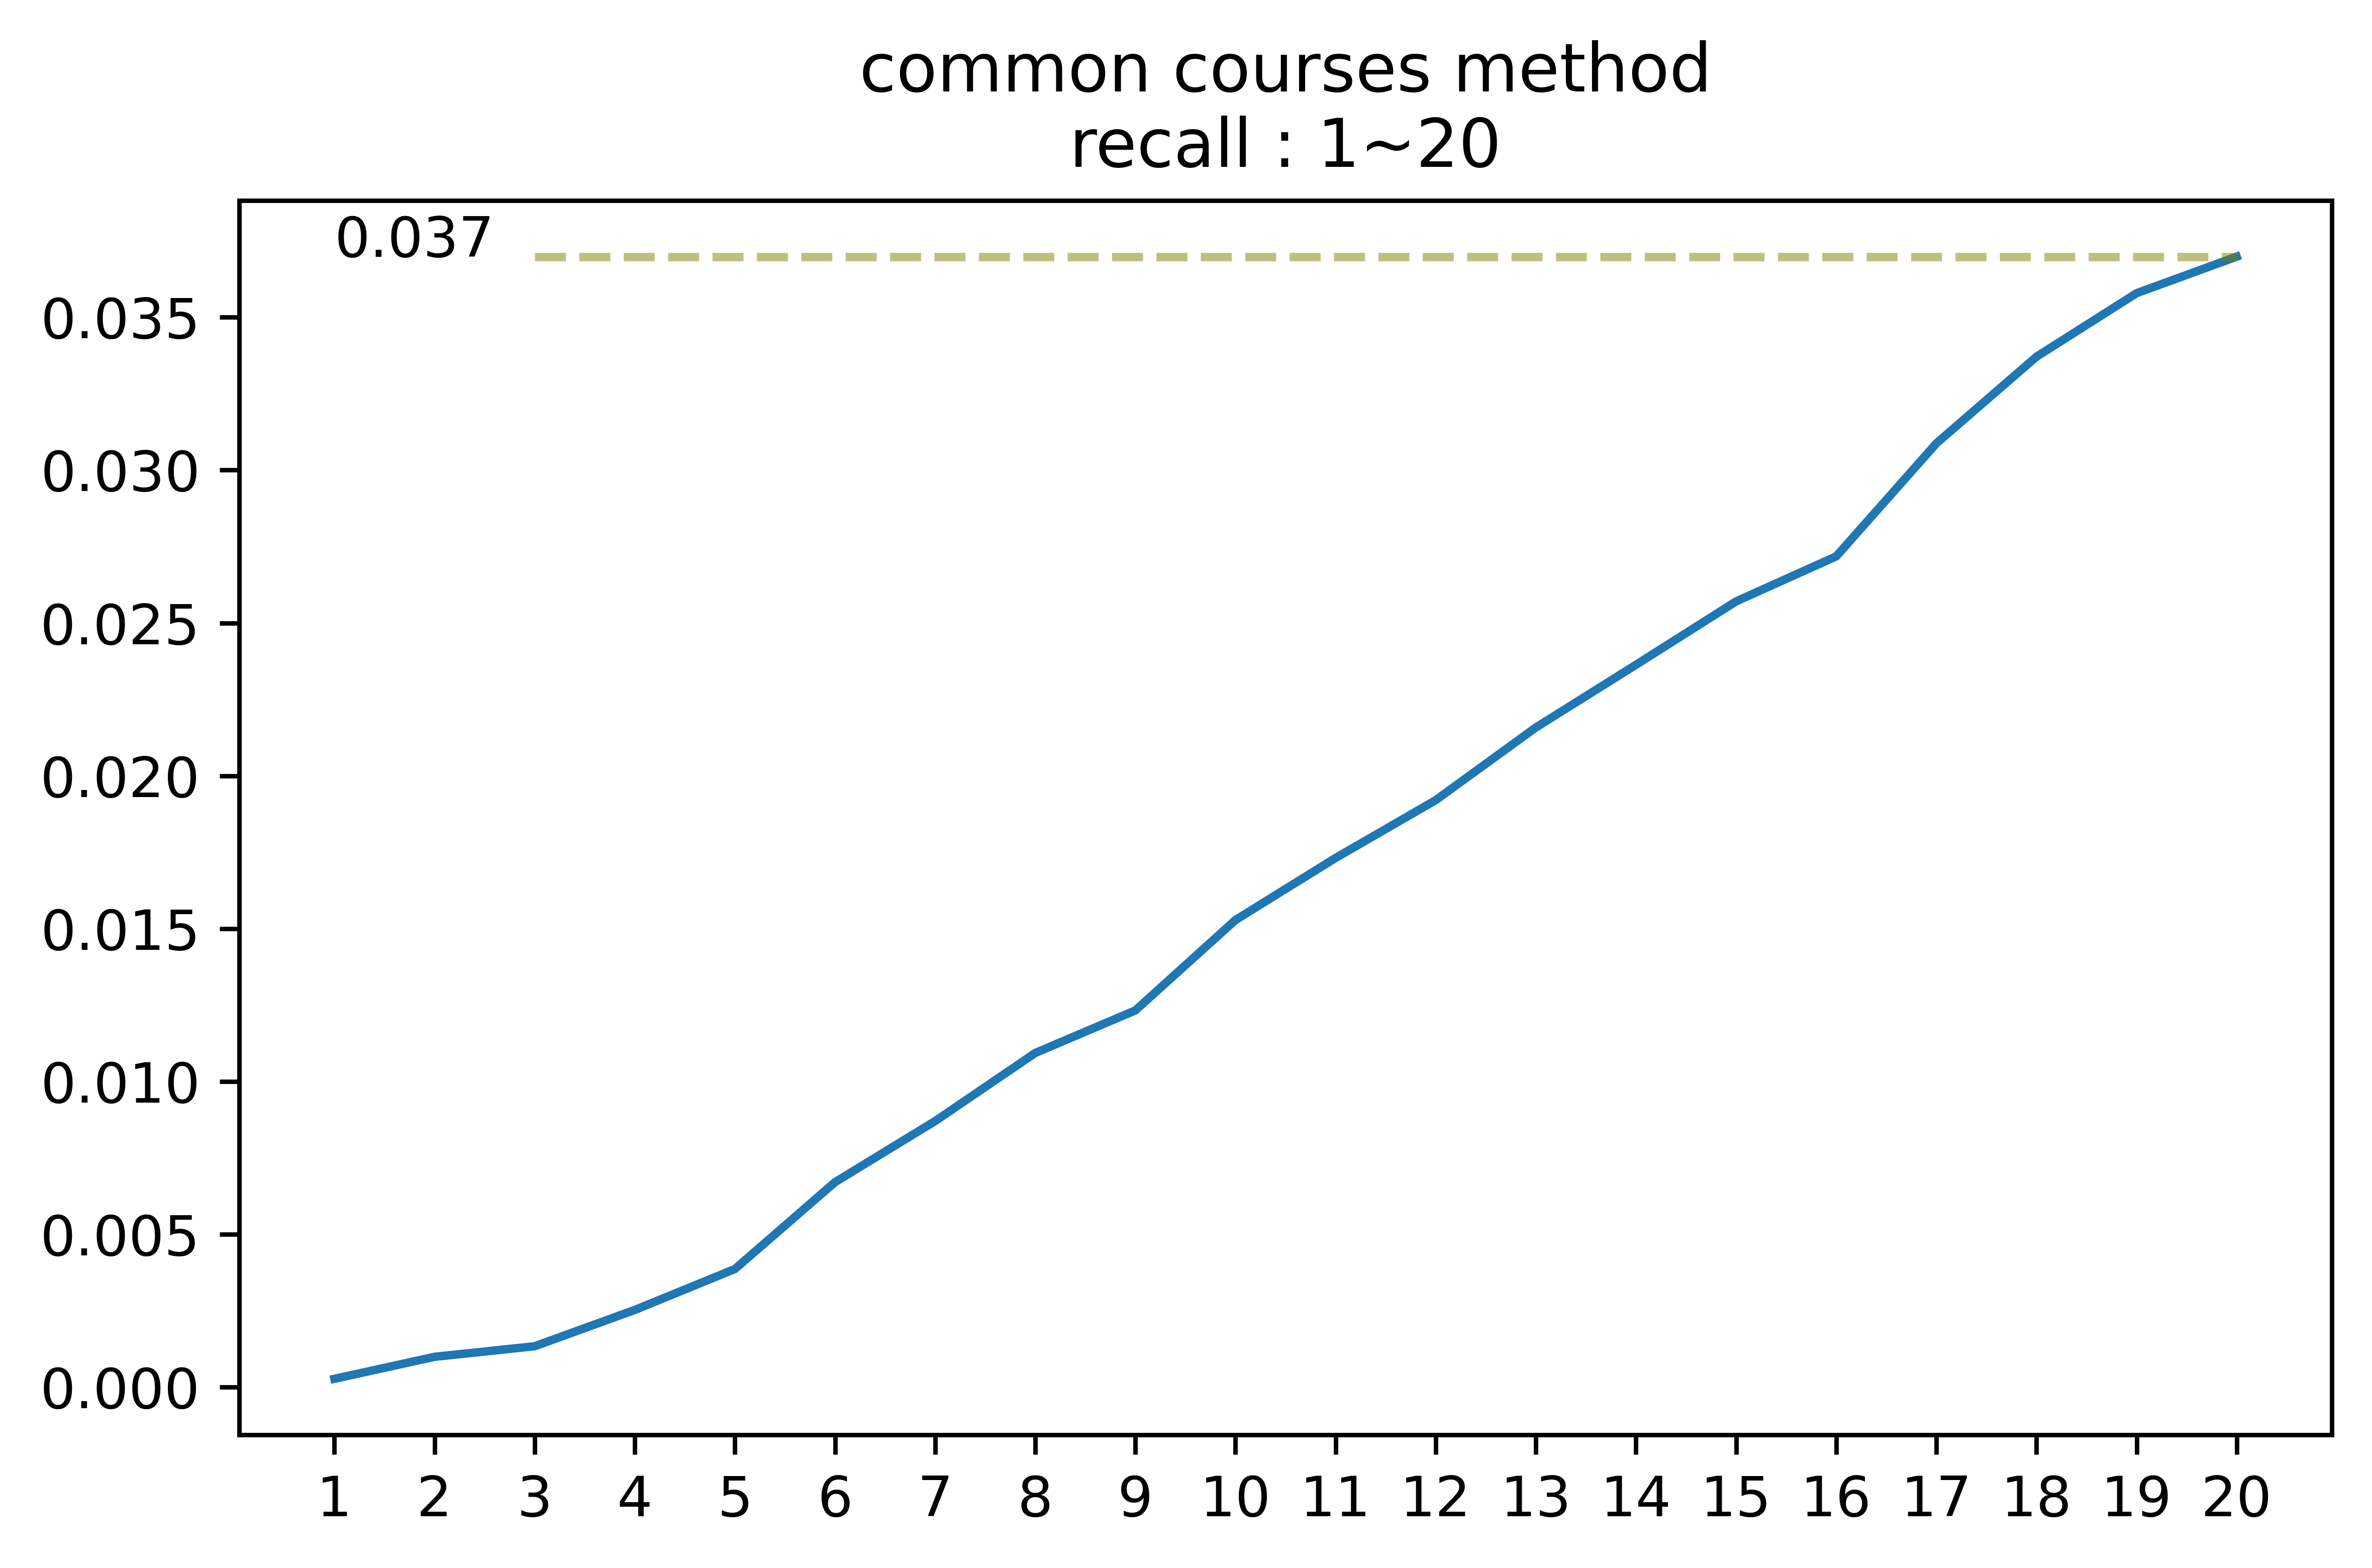

In [11]:
topk = 20
metrics = loadjson(
    os.path.join(
        cbmf_savepath,"nonclustering","metrics","metrics.json"
    )
)
zoom_in_topK(
    metrics=metrics,topk=topk,
    savepath=os.path.join(cbmf_savepath,"nonclustering","metrics"),
    showinline=True
)

### Clustering regularization

In [15]:
cbmatrix = np.load(os.path.join(
    cbmf_savepath, "clustering", "cb.npy")
)
cbmatrix.shape

(201, 110)

#### CBMF

random loss: 23.54499729704937


100%|██████████| 5/5 [00:04<00:00,  1.24it/s, currentbest=0.315, mse=0.315, improve=-0.0000, early=0]


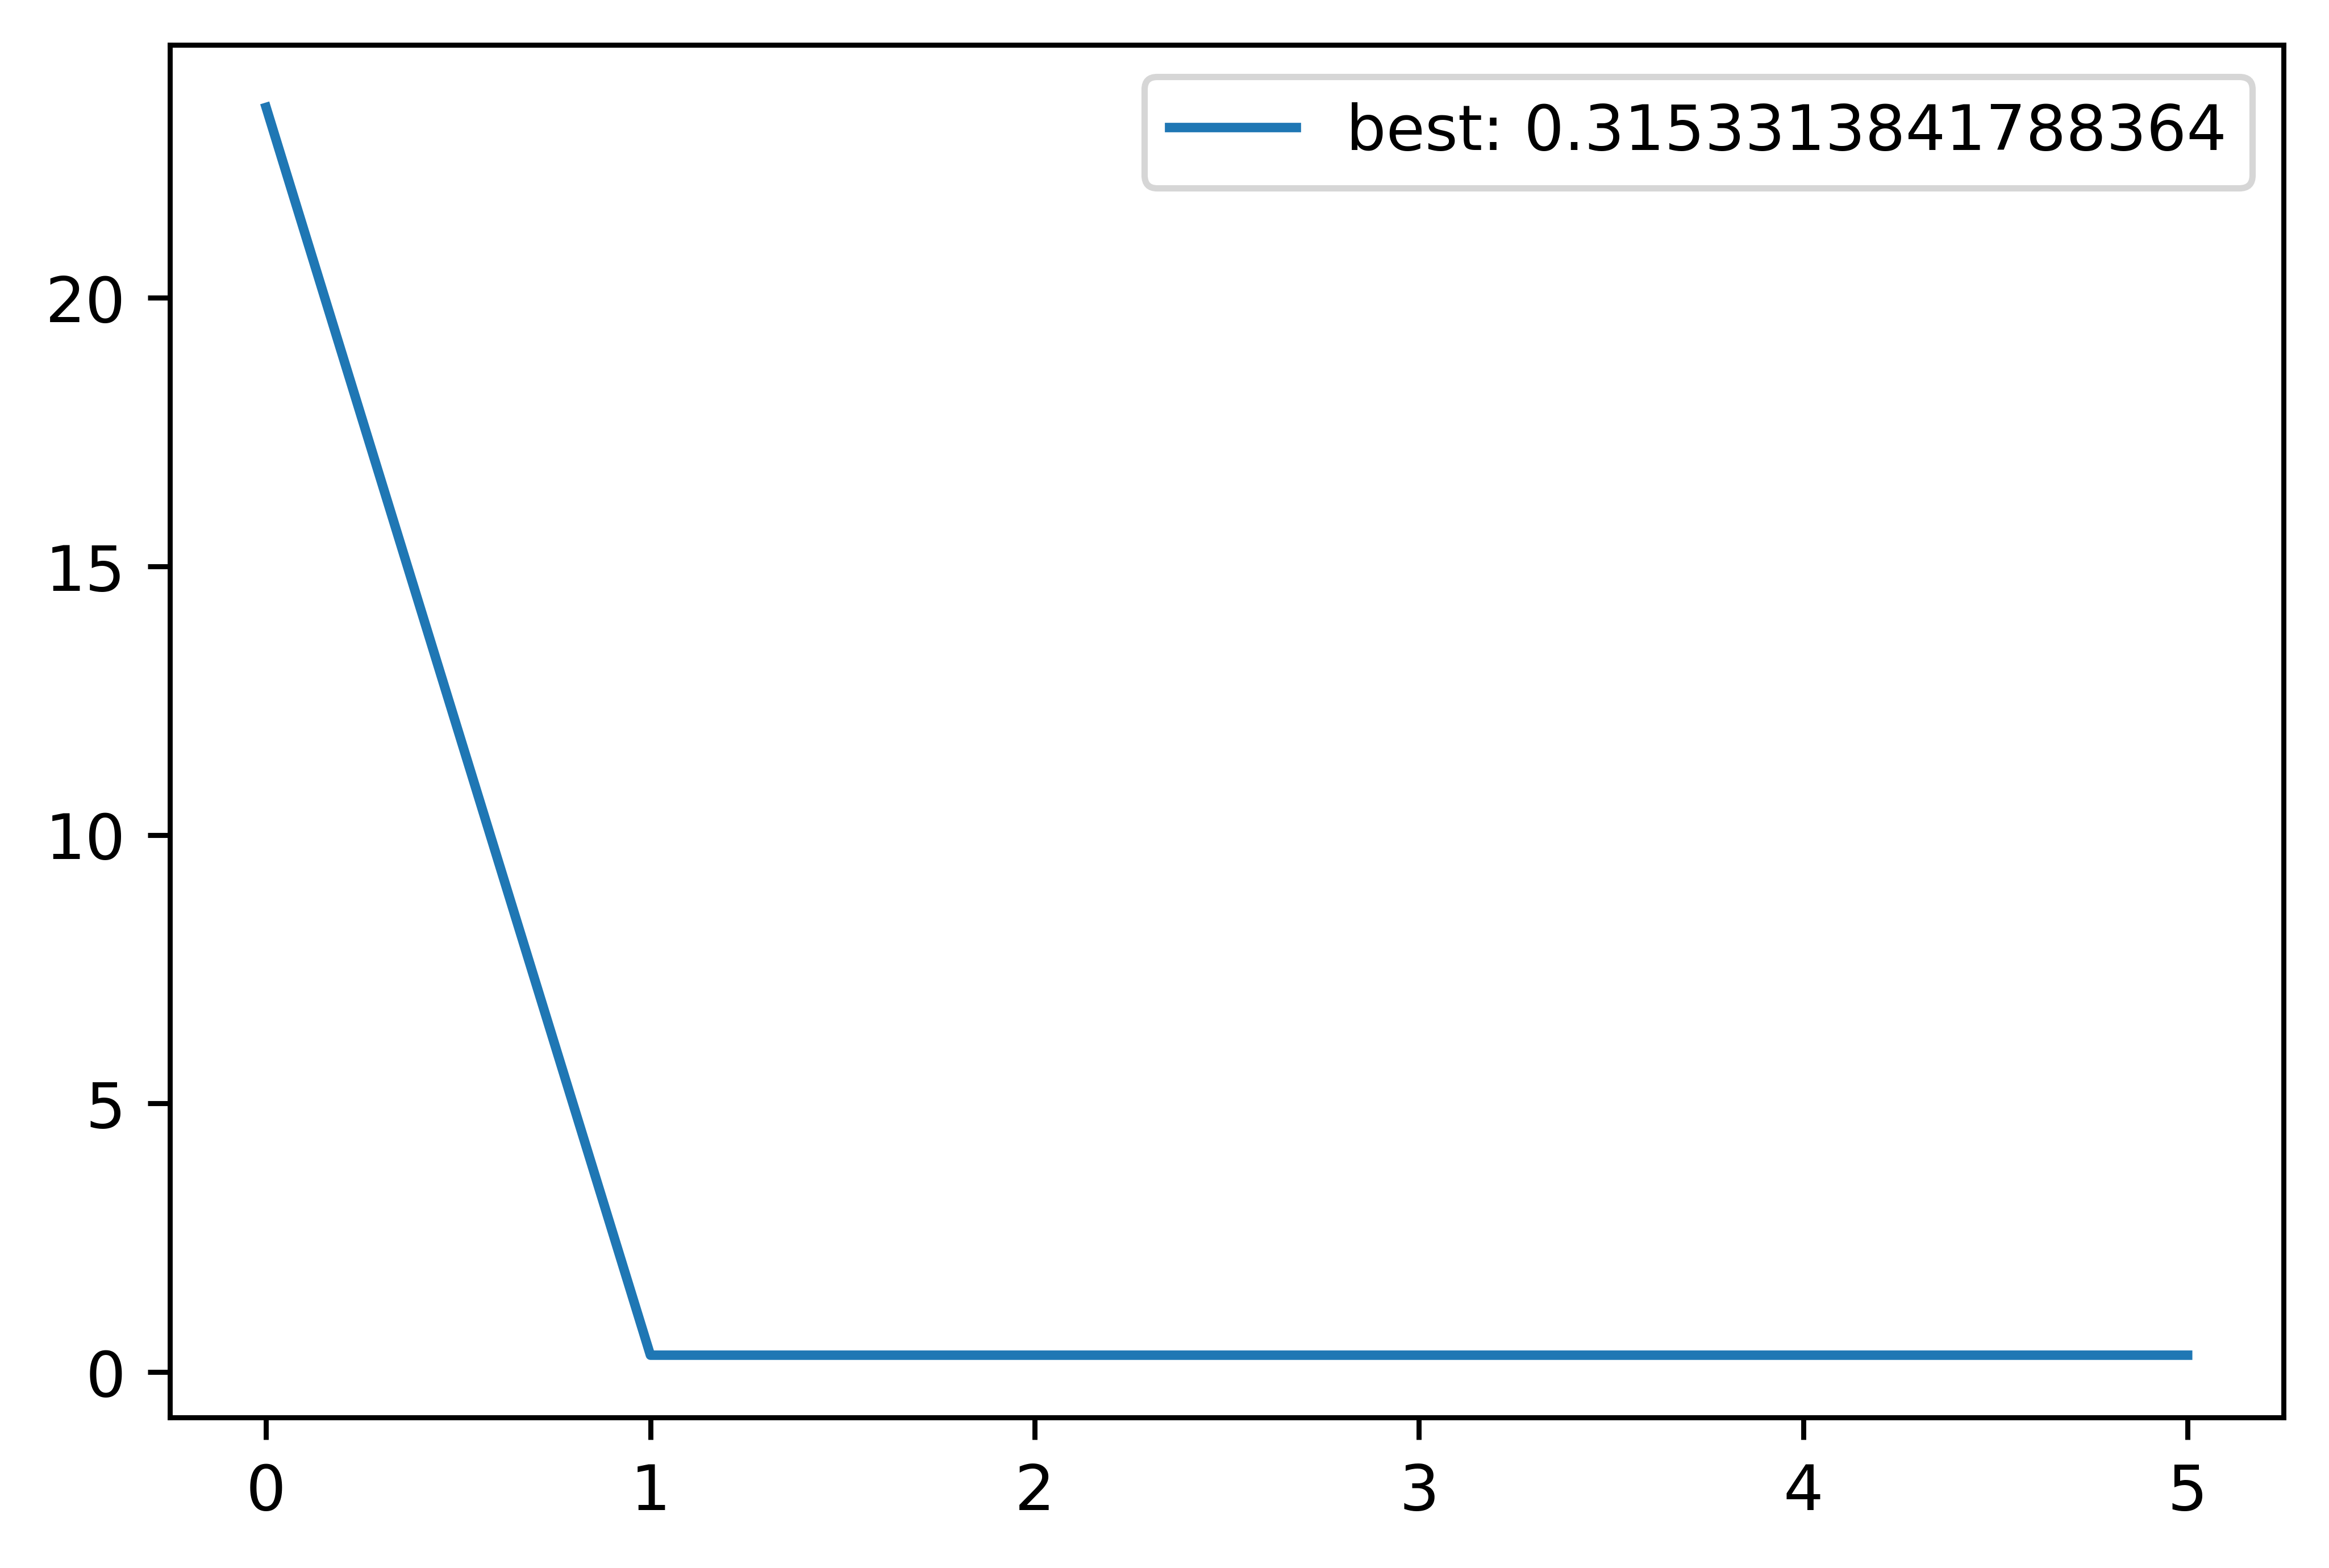

In [19]:
cbmf = WALSMF(
    R=torch.tensor(cbmatrix,dtype=torch.double), latency=20,
    l2_reg=0.9, fill_empty=np.mean(cbmatrix)/2, w_m=0.9
)
h = cbmf.train(
    device=d,tmp_savepath=os.path.join(
        cbmf_savepath, "clustering", "with_w_latency"
    )
)
plotLoss(
    h['loss'], 
    savename=os.path.join(
        cbmf_savepath, "clustering", "wmse.jpg"
    ), showinline=True
)

In [21]:
user_c_l = torch.load(
    os.path.join(
        cbmf_savepath, "clustering", "with_w_latency","user.pt"
    )
)
print(user_c_l.size())
item_c_l = torch.load(
    os.path.join(
        cbmf_savepath, "clustering", "with_w_latency","item.pt"
    )
)
print(item_c_l.size())


torch.Size([201, 20])
torch.Size([110, 20])
torch.Size([201, 110])


#### final prediction

In [22]:
info = loadjson(os.path.join("data","crossdomain","crossdomain_info.json"))
testing_range = info['testing_range']
testing_user=info['testing_user']
print(testing_range)

20575


In [25]:
nonclustering = torch.load(
    os.path.join(cbmf_savepath, 
    "nonclustering","wprediction.pt")
).numpy()[testing_range:, 0:1000]
print(nonclustering.shape)


(1254, 1000)
(201, 110)


In [27]:
user_c_l = user_c_l.numpy()
item_c_l = item_c_l.numpy()

In [26]:
user_clustering = {
    'book':loadjson(
        os.path.join(
            cbmf_savepath,"clustering","bookdataset",
            "userclustering","cluster.json")
        ),
    'course':loadjson(
        os.path.join(
            cbmf_savepath,"clustering","coursedataset",
            "userclustering","cluster.json")
    )
}


In [30]:
alpha = 0.3

In [33]:
rlist = {}
for i, testu in tqdm(enumerate(testing_user), total=len(testing_user)):
    
    cates = nonclustering[i]
    itcoursecluster = np.Inf
    for k,v in user_clustering['course'].items():
        if int(testu) in v:
            itcoursecluster = int(k)
            break
    cluster_suggest = \
        (user_c_l[itcoursecluster,:])@(item_c_l[-10:, :].T)

    cates = (1-alpha)*cates + \
        alpha*np.repeat(cluster_suggest, 100)
        
    rank = np.argsort(-cates).tolist()
    rlist[testu] = list(str(cate) for cate in rank)



100%|██████████| 1254/1254 [00:00<00:00, 1688.05it/s]


In [34]:
writejson(
    rlist, 
    os.path.join(cbmf_savepath, "clustering", "recommendlist.json")
)

### Evaluation

In [35]:
Evaluate(
    result_root = os.path.join(cbmf_savepath, "clustering"), 
    recommendlist = os.path.join(cbmf_savepath, "clustering", "recommendlist.json"),
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=list(str(i) for i in range(1000))
)

result/CBMF/clustering/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [19:51<00:00,  1.19s/it]


Precision_Recall_F1 : result/CBMF/clustering/metrics/metrics.jpg
PR : result/CBMF/clustering/metrics/PR.jpg
ROC : result/CBMF/clustering/metrics/ROC.jpg


#### Zoom-in top k

In [163]:
%autoreload
from RS.utils.plotutils import zoom_in_topk, plot_simple_curve

In [161]:
topk = 20
metrics = loadjson(
    os.path.join(cbmf_savepath,"clustering","metrics", "metrics.json")
)

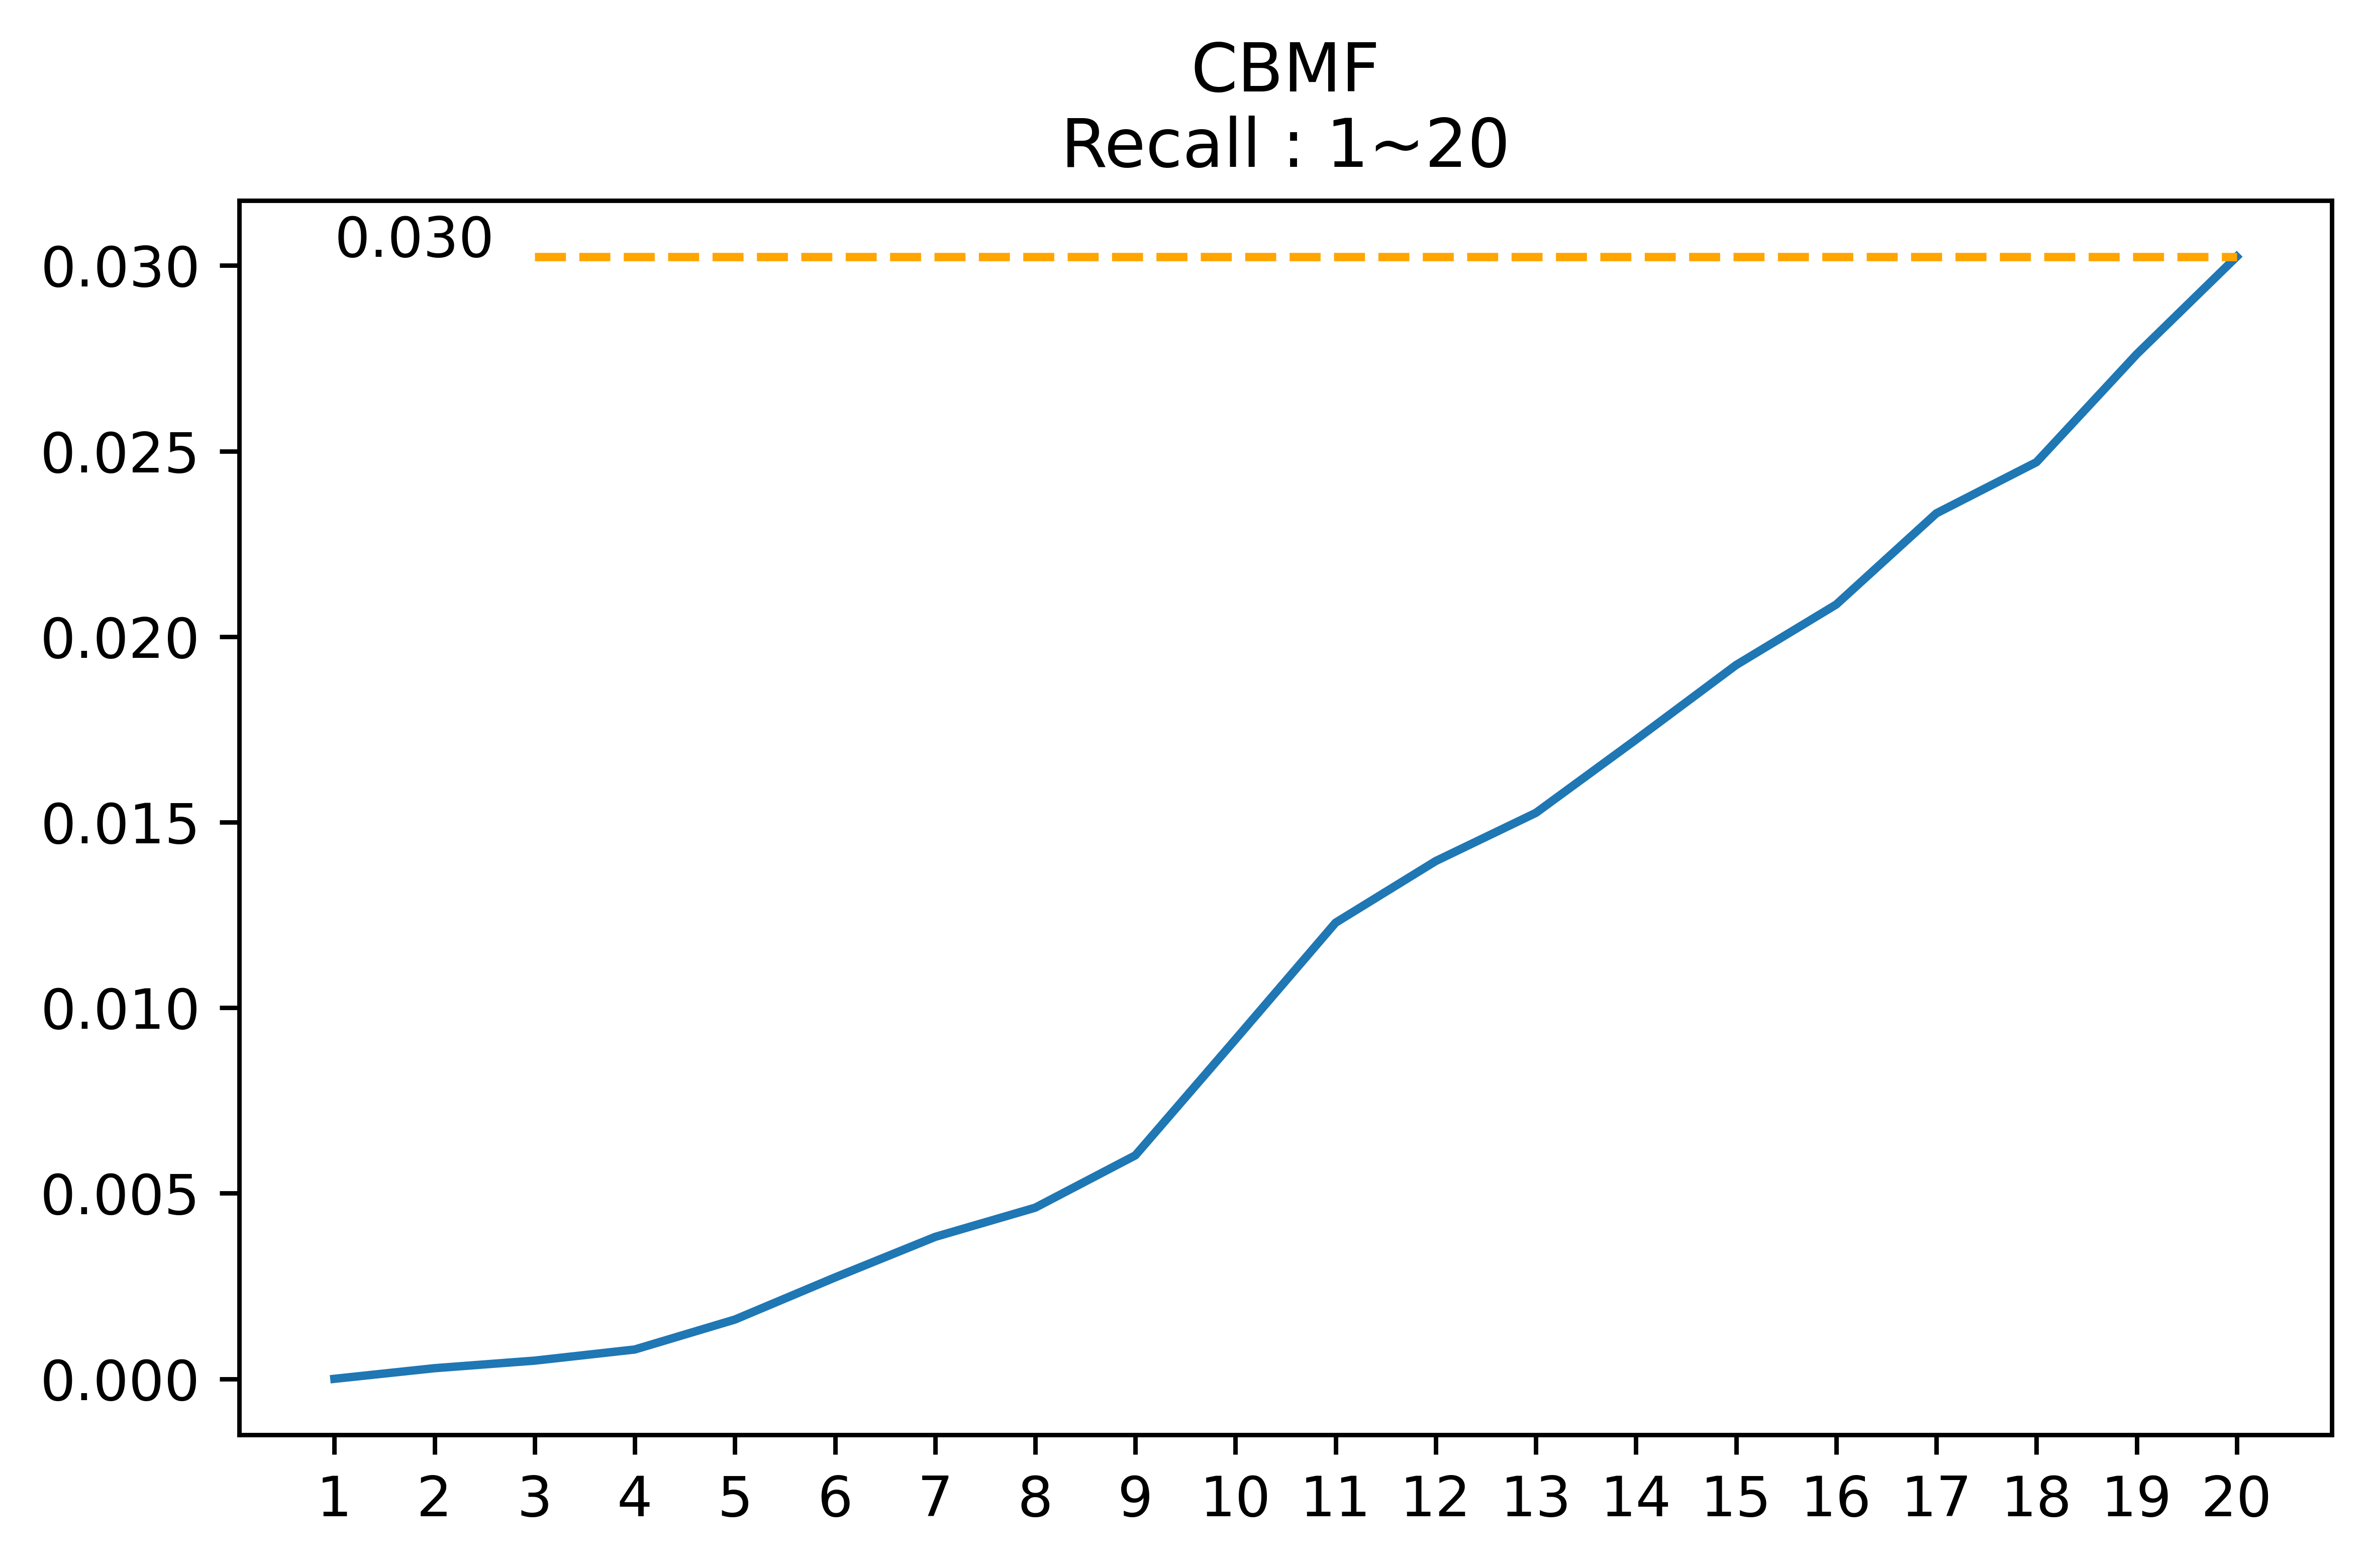

In [164]:
zoom_in_topk(
    whole=metrics['recall'],topk=topk,
    plot_title=f"CBMF\nRecall : 1~{topk}",
    savename=os.path.join(cbmf_savepath,"clustering","metrics",f"recall{topk}.jpg"),
    showinline=True
)

## Comparison Recall for top 20

In [199]:
%autoreload
from RS.utils.plotutils import plot_comparison
cmp_topN = 20

In [172]:
recall_list = {
    "method":[],
    "recall":[]
}
metric_path = os.path.join("metrics", "metrics.json")

In [173]:
popular_metrics = loadjson(
    os.path.join("result", "popular",metric_path)
)
commoncourse_metric = loadjson(
    os.path.join("result", "commoncourse",metric_path)
)
CrossMF_metric = loadjson(
    os.path.join("result", "CBMF" ,"clustering",metric_path)
)

recall_list['method'] = ['popular','commoncourse', 'CrossMF']
recall_list['recall'] = [
    popular_metrics['recall'][:cmp_topN],
    commoncourse_metric['recall'][:cmp_topN], 
    CrossMF_metric['recall'][:cmp_topN]
]

result/Comparsion_recall.jpg


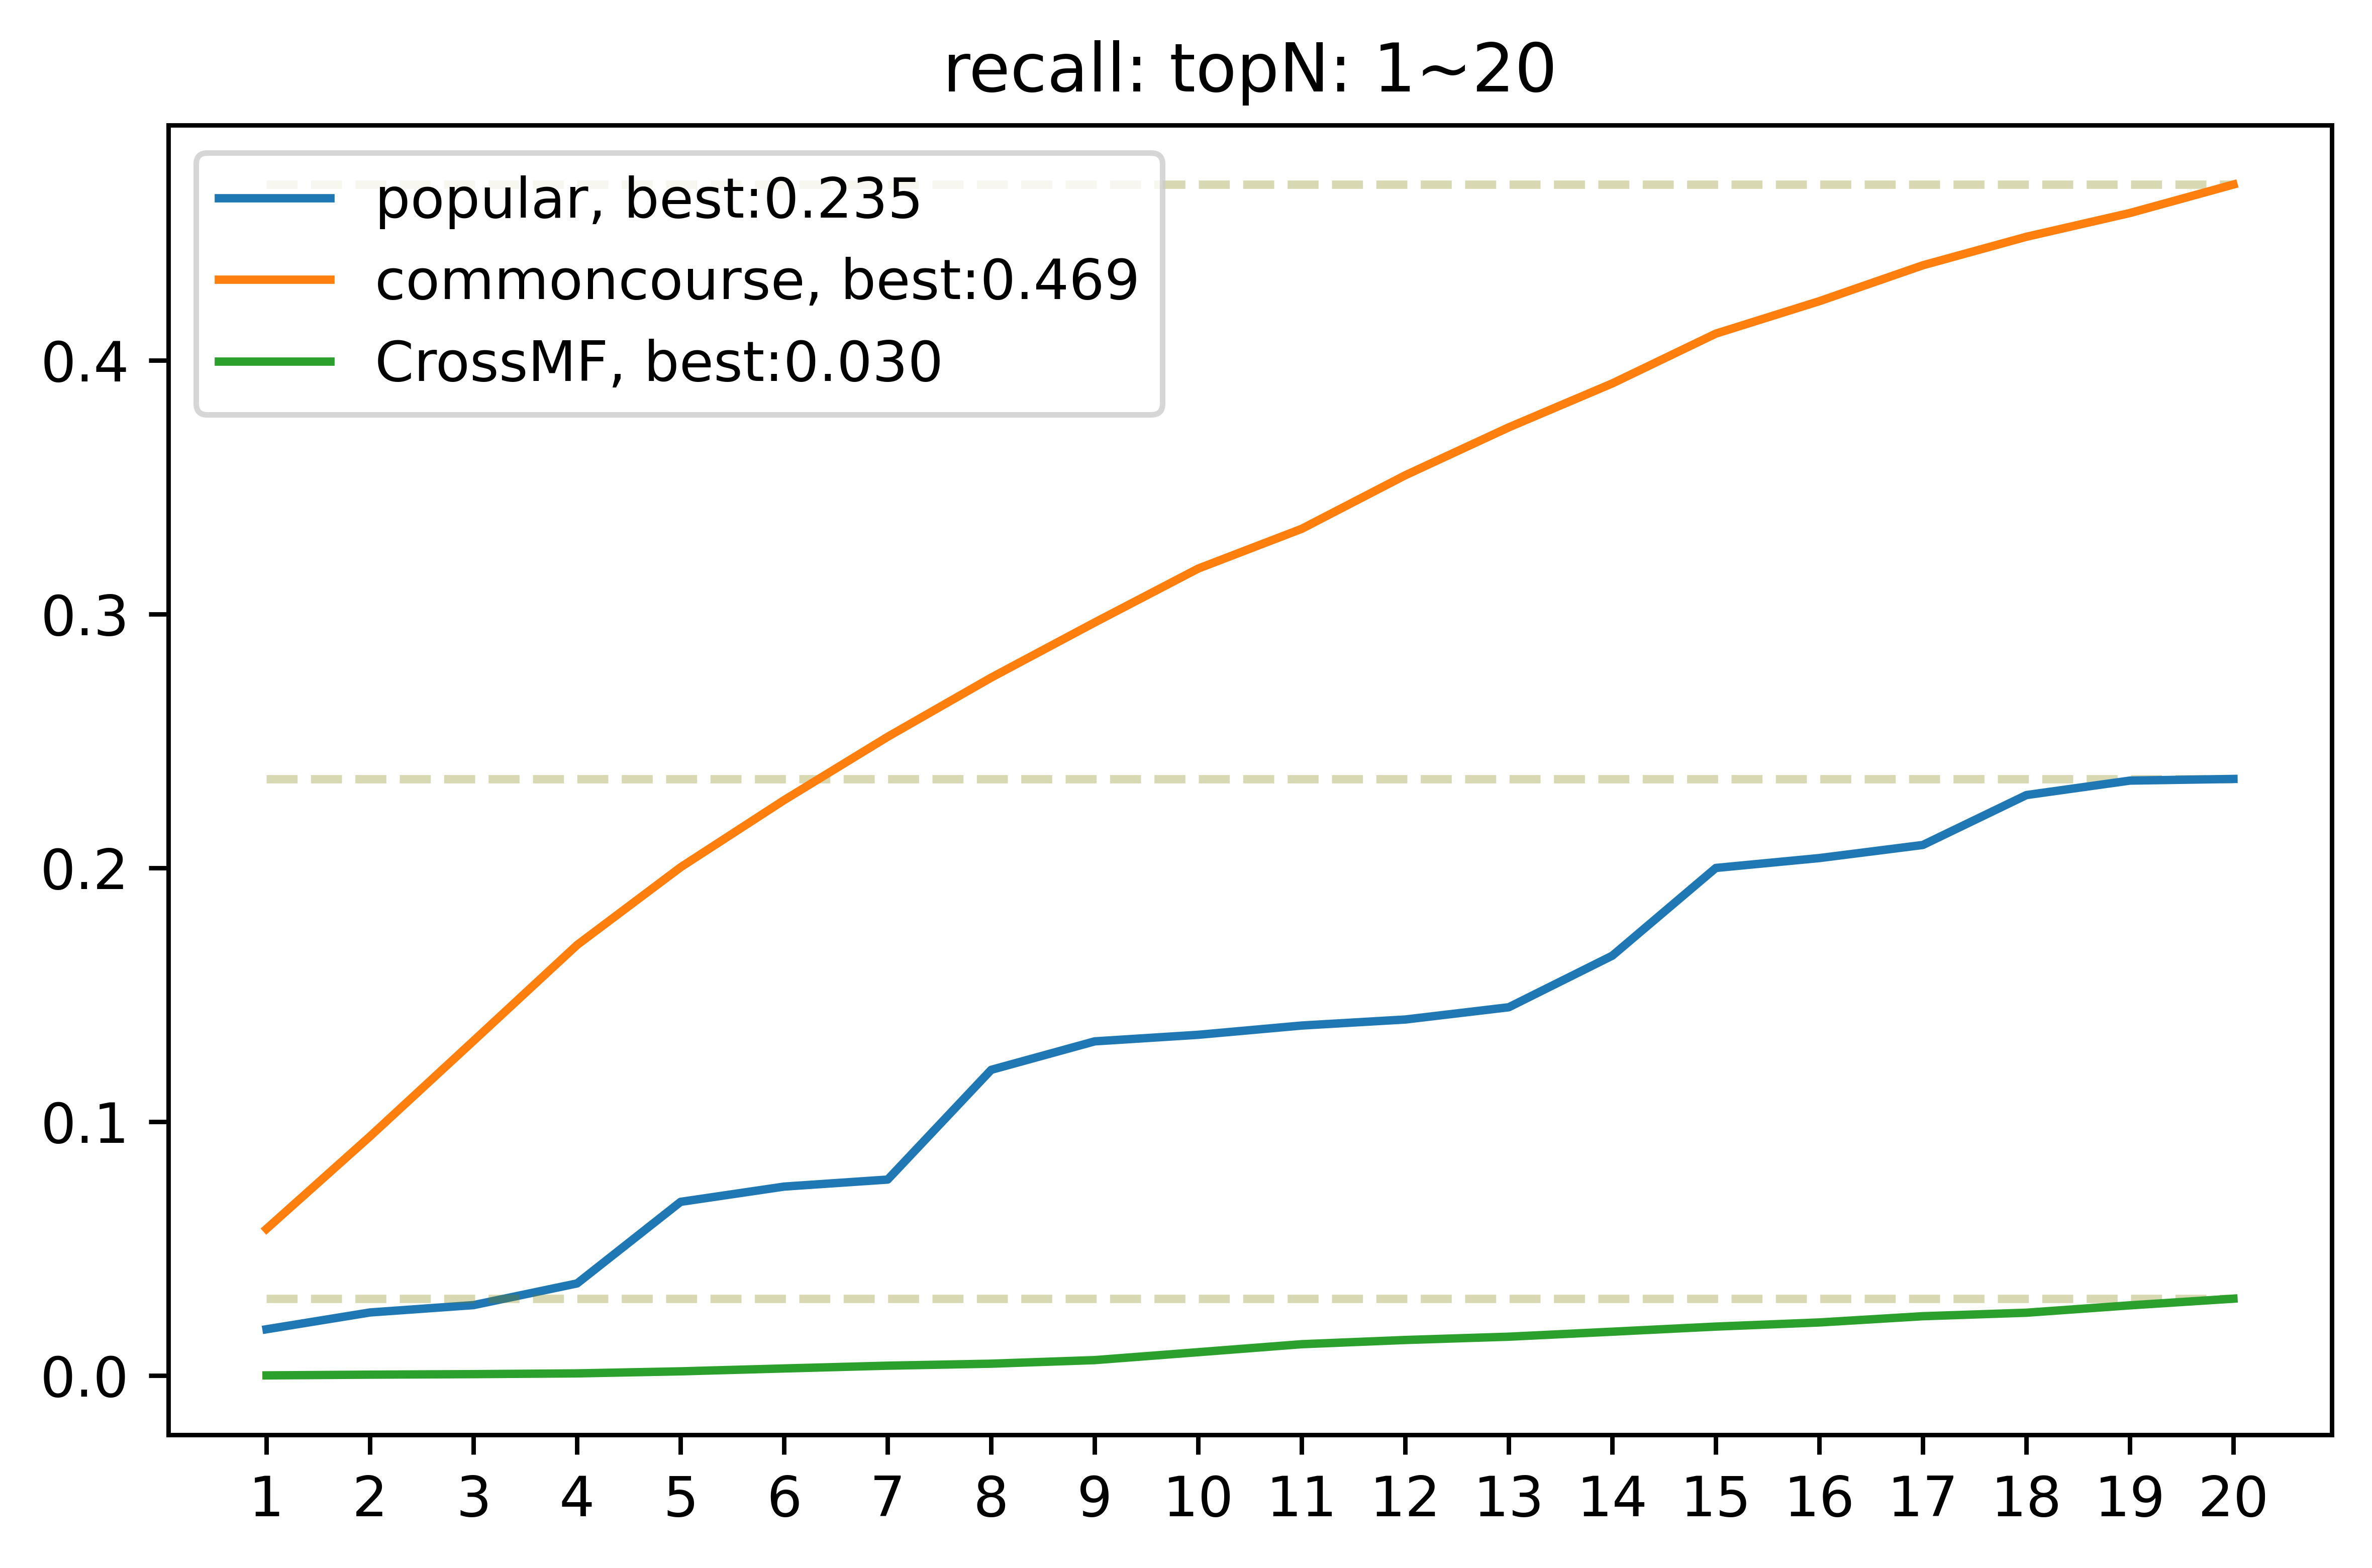

In [200]:
plot_comparison(
    x = recall_list['recall'],
    labels=recall_list['method'],
    savename=os.path.join("result", "Comparsion_recall.jpg"),
    title=f"recall: topN: 1~{cmp_topN}",
    showinline=True
)